# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu

In [4]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [7]:
FONTSIZE = 20

In [8]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

## Inputs & Data

Explanation of each input and where it comes from.

In [9]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [10]:
CHANNEL_MAP_AND_ALL_TRIALS_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")
MERGED_TRIALS_AND_VIDEO = pd.read_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [11]:
OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3"}

In [12]:
OUTCOME_COMPARISONS = {"win_lose": ("win", "lose"), "lose_omission": ("lose", "omission"), "win_rewarded": ("win", "rewarded")}

In [13]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [14]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [15]:
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5 to 10 cm/s", 3: "10cm/s+"}

In [16]:
MIN_VELOCITY = 0
MAX_VELOCITY = 2.5

In [17]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 6, "high_freq": 11}, "beta": {"low_freq": 20, "high_freq": 31}, "gamma": {"low_freq": 30, "high_freq": 51}}
BAND_TO_FREQ = {"theta": (6,11), "beta": (20,31), "gamma": (30,51)}
BAND_TO_FREQ = {"theta": (6,11), "gamma": (30,51)}

In [18]:
GROUPINGS = "trial_outcome"

In [19]:
FONTSIZE=20

In [20]:
MERGED_TRIALS_AND_VIDEO.head()

time                            recording_dir  \
0  30950500  20221214_125409_om_and_comp_6_1_and_6_3   
1  32550496  20221214_125409_om_and_comp_6_1_and_6_3   
2  34350494  20221214_125409_om_and_comp_6_1_and_6_3   
3  35950496  20221214_125409_om_and_comp_6_1_and_6_3   
4  37450494  20221214_125409_om_and_comp_6_1_and_6_3   

                                      recording_file  time_stamp_index  \
0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          27998597   
1  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          29598593   
2  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          31398591   
3  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          32998593   
4  20221214_125409_om_and_comp_6_1_top_1_base_2_v...          34498591   

                                          video_file  video_frame  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        28574   
1  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        30569   
2  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        32813   
3  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        34807   
4  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...        36677   

   video_number             subject_info competition_closeness  \
0           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   
1           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   
2           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   
3           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   
4           1.0  6_1_top_1_base_2_vs_6_3          win_non_comp   

                                  video_name  ...  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   

  baseline-trial_subject_thorax-to-agent_distance_chunked  \
0  [24.979701762391695, 22.97606870054344, 21.618...        
1  [17.180542025000065, 15.67928472897514, 16.254...        
2  [10.481987827455116, 13.904524717531153, 20.77...        
3  [13.743103594851767, 13.8505713096129, 12.9344...        
4  [25.23454020309797, 25.108996390924958, 25.390...        

    baseline_subject_thorax-to-agent_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

       trial_subject_thorax-to-agent_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

   baseline-trial_subject_thorax-to-agent_distance_binned  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...        

  baseline_subject-agent_to-reward-port-distance-ratio_chunked  \
0  [0.07685848975558031, 0.1003391658674107, 0.10...             
1  [0.11861875495254547, 0.12029190228627576, 0.1...             
2  [0.17237067317464214, 0.11794679333842759, 0.1...             
3  [0.19830815990682205, 0.21011648430351057, 0.2...             
4  [0.07701991514325422, 0.07278014127330514, 0.0...             

  trial_subject-agent_to-reward-port-distance-ratio_chunked  \
0  [0.799555206323743, 2.13297822194092, 3.238672...          
1  [0.15572270056543616, 0.10222129722911243, 0.0...          
2  [0.11035872114328305, 0.10949816125115958, 0.0...          
3  [0.0964704025249825, 0.08519405428

In [21]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                       vHPC_baseline-trial_lfp_trace  \
0  [-0.07045184, -0.0958607, -0.054282565, 0.1512...   
1  [0.30606127, 0.22405995, 0.28873706, 0.4100066...   
2  [-1.2300198, -1.2323297, -1.3039365, -1.096045...   
3  [0.1605378, 0.4169363, 0.64561605, 0.6756447, ...   
4  [-0.30952612, 0.19056645, 0.4331056, 0.3638087...   

                              BLA_baseline_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                                 BLA_trial_lfp_trace  \
0  [0.31159526, 0.35909453, 0.18239723, -0.509192...   
1  [0.020899683, -0.05129922, 0.113998264, -0.416...   
2  [0.6896895, 1.3983787, 1.7574733, 1.4287783, 1...   
3  [2.6789594, 2.3939636, 2.2096665, 1.97597, 1.8...   
4  [-0.18809713, 0.108298354, -0.66878986, -0.944...   

                        BLA_baseline-trial_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                               LH_baseline_lfp_trace  \
0  [3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...   
1  [-1.1575702, -1.2699852, -1.3489795, -1.427973...   
2  [-0.20356221, -0.08203254, -0.18837102, -0.142...   
3  [-2.4792056, -2.1480372, -1.8259835, -1.677109...   
4  [-2.1176548, -1.4522797, -1.0360405, -1.108958...   

                                  LH_trial_lfp_trace  \
0  [0.78082824, 1.1788379, 0.8415931, -0.40104795...   
1  [0.91754913, 0.4466216, 0.64410734, 0.03342066...   
2  [-0.58941895, 0.25521234, 0.66233677, 0.416239...   
3  [2.7587237, 2.233108, 1.4796239, 0.93274033, 1...   
4  [0.5104247, 1.4613944, 0.5468836, -0.036458906...   

      

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [22]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [23]:
def nested_dict():
    return defaultdict(dict)

In [24]:
def mean_of_counter(counter):
    # Extract values from the Counter and calculate the mean
    values = list(counter.values())
    return sum(values) / len(values) if values else 0  # Prevent division by zero

In [25]:
def adjust_lightness(color, amount=0.5):
    """
    Adjusts the lightness of the given color by the provided amount.
    :param color: Input color in some format that matplotlib's `to_rgb` can handle.
    :param amount: Amount to adjust. > 1 for lighter, < 1 for darker.
    :return: Adjusted color.
    """
    import colorsys
    c = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(h, max(0, min(1, amount * l)), s)

In [26]:
def generate_gradient_colors(base_color, num_colors=10):
    """
    Generate gradient colors based on a base color.
    
    :param base_color: The base color to create a gradient from.
    :param num_colors: The number of gradient colors to generate.
    :return: List of colors.
    """
    # Convert base color to HLS (Hue, Lightness, Saturation)
    h, l, s = colorsys.rgb_to_hls(*mcolors.to_rgb(base_color))

    # Determine the step size for lightness
    middle_index = num_colors // 2
    lightness_step = l / (middle_index if middle_index > 0 else 1)

    colors = []
    for i in range(num_colors):
        if i < middle_index:
            # For the lighter colors (before the middle)
            new_lightness = l + (middle_index - i) * lightness_step
        elif i == middle_index:
            # The middle color remains the base color
            new_lightness = l
        else:
            # For the darker colors (after the middle)
            new_lightness = l - (i - middle_index) * lightness_step

        # Ensure new lightness is within the valid range [0, 1]
        new_lightness = max(0, min(new_lightness, 1))

        new_color = colorsys.hls_to_rgb(h, new_lightness, s)
        colors.append(new_color)

    return colors

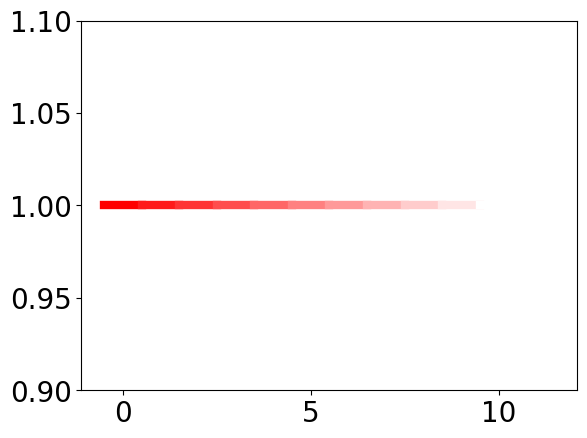

In [27]:
# Original color
original_color = 'red'  # Can be any color matplotlib understands

# Generate lighter versions
lighter_colors = [adjust_lightness(original_color, amount=1+(0.1*i)) for i in range(12)]

# Plotting to demonstrate the colors
for i, color in enumerate(lighter_colors):
    plt.plot([i-0.5, i+0.5], [1, 1], color=color, linewidth=6)  

plt.ylim(0.9, 1.1)
plt.show()

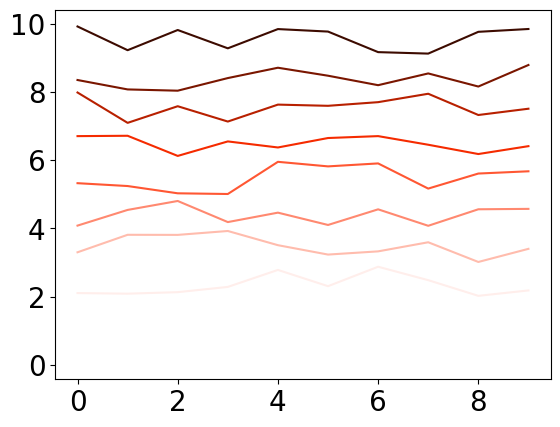

In [28]:
# Base color
base_color = '#ff5733'  # Reddish color

# Number of colors you want in the gradient
num_colors = 10

# Generate gradient colors
gradient_colors = generate_gradient_colors(base_color, num_colors)

# Set the color cycle to use the gradient colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=gradient_colors)

# Test by plotting some data
for i in range(num_colors):
    plt.plot(np.arange(10), np.random.rand(10) + i)

plt.show()

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [29]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




In [30]:
CHANNEL_MAP_AND_ALL_TRIALS_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baseline-trial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baseline-trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'BLA_baseline-trial_lfp_trace', 'LH_baseline_lfp_trace',
       'LH_trial_lfp_trace', 'LH_baseline-trial_lfp_trace',
       'MD_baseline_lfp_trace', 'MD_trial_lfp_trace',
       'MD_baseline-trial_lfp_trace'],
      dtype='object')

In [31]:
MERGED_TRIALS_AND_VIDEO.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'track_names', 'subject_and_tracks_list',
       'subject_id', 'agent_id', 'corner_path', 'corner_parts', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'box_bottom_left',
       'reward_po

### Merging LFP Trace dataframe and SLEAP pose tracking

In [32]:
merge_columns = ["time", "recording_file", "current_subject", "video_number"]
# Find columns in df2 that are not in merge_columns and also exist in df1, then drop them from df2
cols_to_drop = [col for col in CHANNEL_MAP_AND_ALL_TRIALS_DF.columns if col not in merge_columns and col in MERGED_TRIALS_AND_VIDEO.columns]
CHANNEL_MAP_AND_ALL_TRIALS_DF = CHANNEL_MAP_AND_ALL_TRIALS_DF.drop(columns=cols_to_drop)

In [33]:
# MERGED_LFP_AND_SLEAP = pd.merge(left=CHANNEL_MAP_AND_ALL_TRIALS_DF, right=MERGED_TRIALS_AND_VIDEO, on=merge_columns, how="right")
MERGED_LFP_AND_SLEAP = CHANNEL_MAP_AND_ALL_TRIALS_DF

In [34]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0   6310663  20221202_134600_omission_and_competition_subje...           1.0   
1   7910662  20221202_134600_omission_and_competition_subje...           1.0   
2   9710660  20221202_134600_omission_and_competition_subje...           1.0   
3  11310658  20221202_134600_omission_and_competition_subje...           1.0   
4  12810657  20221202_134600_omission_and_competition_subje...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             6.1  [1.7927227, 1.6862243, 1.5996945, 1.5508827, 1...   
1             6.1  [1.1825758, 1.1004833, 1.1692635, 1.0627651, 0...   
2             6.1  [-1.2380437, -1.266887, -1.2247314, -0.9651416...   
3             6.1  [-1.9768763, -1.985751, -1.8859088, -1.712849,...   
4             6.1  [-0.56577265, 0.24627751, 0.61902183, 0.421556...   

                                mPFC_trial_lfp_trace  \
0  [0.6700523, 0.9340795, 0.76323843, -0.04437432...   
1  [1.0405779, 0.70111436, 0.73883253, 0.36386946...   
2  [0.27512082, 0.8231437, 1.0627651, 0.79651916,...   
3  [2.3096836, 2.236466, 1.72838, 0.9118924, 0.47...   
4  [-0.04659304, 0.7122079, 0.30396414, 0.0709989...   

                       mPFC_baseline-trial_lfp_trace  \
0  [1.7927227, 1.6862243, 1.5996945, 1.5508827, 1...   
1  [1.1825758, 1.1004833, 1.1692635, 1.0627651, 0...   
2  [-1.2380437, -1.266887, -1.2247314, -0.9651416...   
3  [-1.9768763, -1.985751, -1.8859088, -1.712849,...   
4  [-0.56577265, 0.24627751, 0.61902183, 0.421556...   

                             vHPC_baseline_lfp_trace  \
0  [-0.07045184, -0.0958607, -0.054282565, 0.1512...   
1  [0.30606127, 0.22405995, 0.28873706, 0.4100066...   
2  [-1.2300198, -1.2323297, -1.3039365, -1.096045...   
3  [0.1605378, 0.4169363, 0.64561605, 0.6756447, ...   
4  [-0.30952612, 0.19056645, 0.4331056, 0.3638087...   

                                vHPC_trial_lfp_trace  \
0  [1.5487856, 1.5337712, 1.55918, 1.1861318, 0.9...   
1  [0.03233855, -0.27256778, -0.39383733, -0.6513...   
2  [0.05659246, 0.46197927, 0.74609655, 0.6421512...   
3  [-1.8040291, -2.254459, -2.6228874, -2.9947808...   
4  [0.20904562, 0.80153406, 0.56707954, 0.4192462...   

                       vHPC_baseline-trial_lfp_trace  \
0  [-0.07045184, -0.0958607, -0.054282565, 0.1512...   
1  [0.30606127, 0.22405995, 0.28873706, 0.4100066...   
2  [-1.2300198, -1.2323297, -1.3039365, -1.096045...   
3  [0.1605378, 0.4169363, 0.64561605, 0.6756447, ...   
4  [-0.30952612, 0.19056645, 0.4331056, 0.3638087...   

                              BLA_baseline_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                                 BLA_trial_lfp_trace  \
0  [0.31159526, 0.35909453, 0.18239723, -0.509192...   
1  [0.020899683, -0.05129922, 0.113998264, -0.416...   
2  [0.6896895, 1.3983787, 1.7574733, 1.4287783, 1...   
3  [2.6789594, 2.3939636, 2.2096665, 1.97597, 1.8...   
4  [-0.18809713, 0.108298354, -0.66878986, -0.944...   

                        BLA_baseline-trial_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                               LH_baseline_lfp_trace  \
0  [3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...   
1  [-1.1575702, -1.2699852, -1.3489795, -1.427973...   
2  [-0.20356221, -0.08203254, -0.18837102, -0.142...   
3  [-2.4792056, -2.1480372, -1.8259835, -1.677109...   
4  [-2.1176548, -1.4522797, -1.0360405, -1.108958...   

                                  LH_trial_lfp_trace  \
0  [

In [35]:
MERGED_LFP_AND_SLEAP["recording_file"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
       '20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
       '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

In [36]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col]

In [37]:
trial_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col and "baseline" not in col])
baseline_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_lfp_trace" in col and "trial" not in col])

In [38]:
trial_trace_columns

['BLA_trial_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_trial_lfp_trace',
 'mPFC_trial_lfp_trace',
 'vHPC_trial_lfp_trace']

- Getting the trace column pairs

In [39]:
trial_brain_region_pairs = generate_pairs(trial_trace_columns)
trial_brain_region_pairs = sorted(trial_brain_region_pairs)
baseline_brain_region_pairs = generate_pairs(baseline_trace_columns)
baseline_brain_region_pairs = sorted(baseline_brain_region_pairs)

In [40]:
trial_brain_region_pairs

[('BLA_trial_lfp_trace', 'LH_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('mPFC_trial_lfp_trace', 'vHPC_trial_lfp_trace')]

In [41]:
baseline_brain_region_pairs

[('BLA_baseline_lfp_trace', 'LH_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('mPFC_baseline_lfp_trace', 'vHPC_baseline_lfp_trace')]

- Getting just the region names

In [42]:
all_pair_base_name = []
for region_1, region_2 in trial_brain_region_pairs:
    all_pair_base_name.append("{}_{}".format(region_1.split("_")[0], region_2.split("_")[0]))
all_pair_base_name = sorted(all_pair_base_name)

In [43]:
all_pair_base_name

['BLA_LH',
 'BLA_MD',
 'BLA_mPFC',
 'BLA_vHPC',
 'LH_MD',
 'LH_mPFC',
 'LH_vHPC',
 'MD_mPFC',
 'MD_vHPC',
 'mPFC_vHPC']

# Granger's Causality

In [44]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

- Calculating the granger

In [45]:
trial_brain_region_pairs

[('BLA_trial_lfp_trace', 'LH_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('mPFC_trial_lfp_trace', 'vHPC_trial_lfp_trace')]

In [46]:
raise ValueError()

ValueError: 

In [47]:
MERGED_LFP_AND_SLEAP = pd.read_pickle("./proc/per_trial_granger.pkl")

In [48]:
MERGED_LFP_AND_SLEAP["BLA_LH_trial_frequencies"].iloc[0]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [49]:
GROUPINGS = "trial_outcome"

In [50]:
all_frequencies = MERGED_LFP_AND_SLEAP["BLA_LH_trial_frequencies"].iloc[0]

In [51]:
trial_brain_region_pairs

[('BLA_trial_lfp_trace', 'LH_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('mPFC_trial_lfp_trace', 'vHPC_trial_lfp_trace')]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


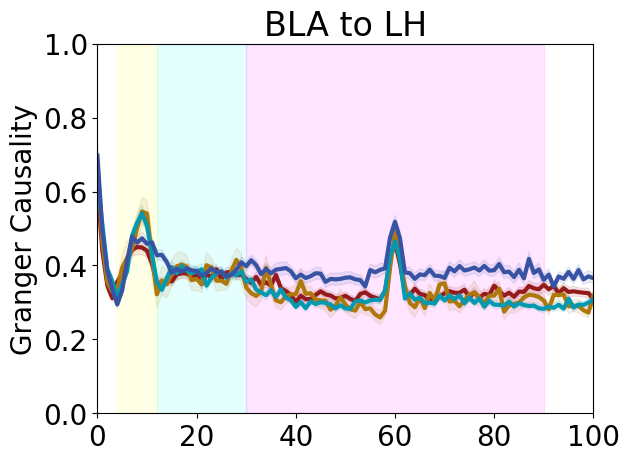

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


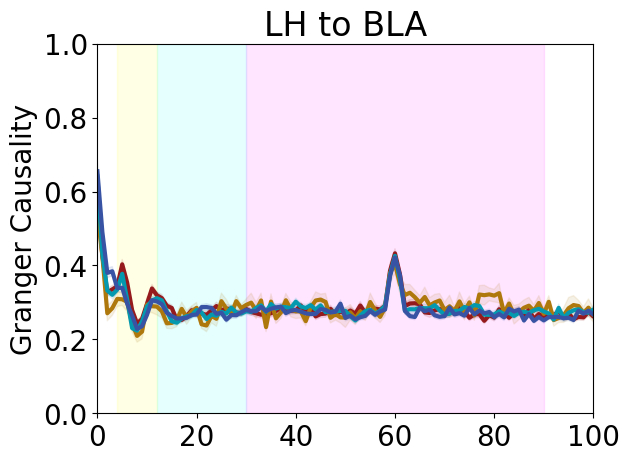

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


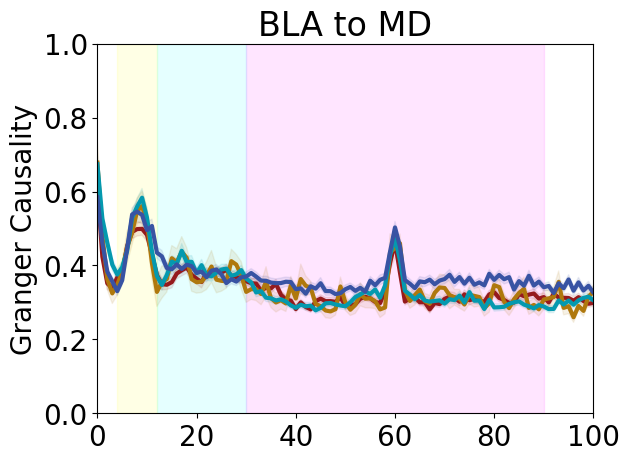

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


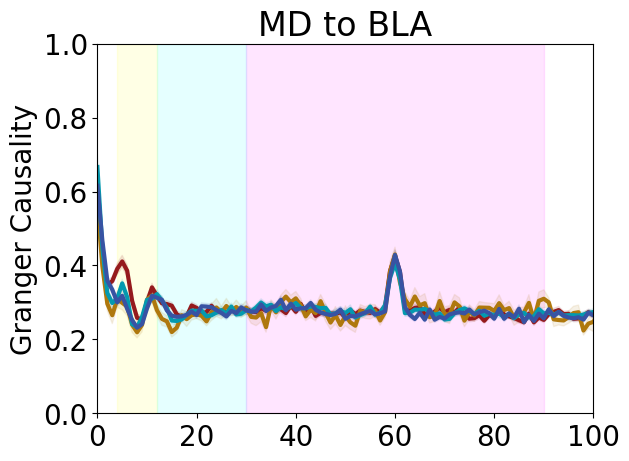

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


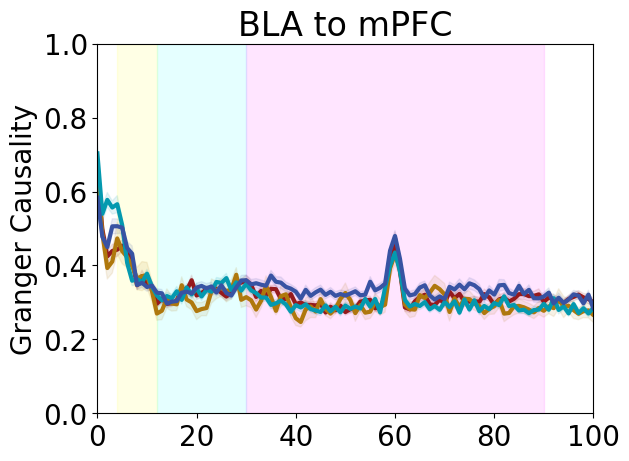

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


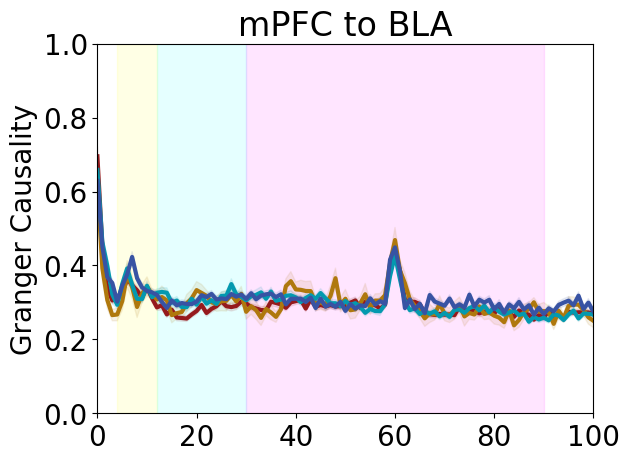

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


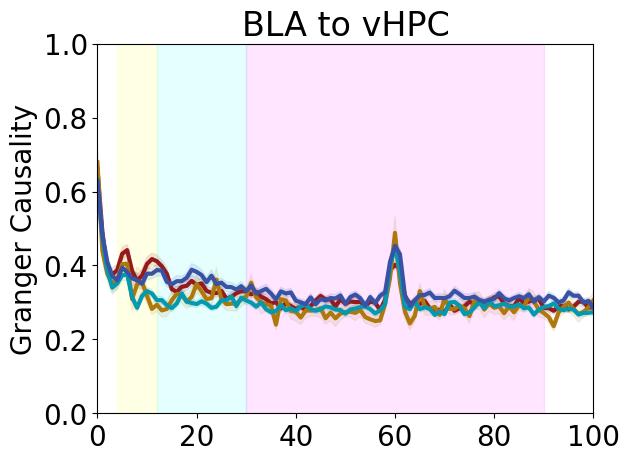

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


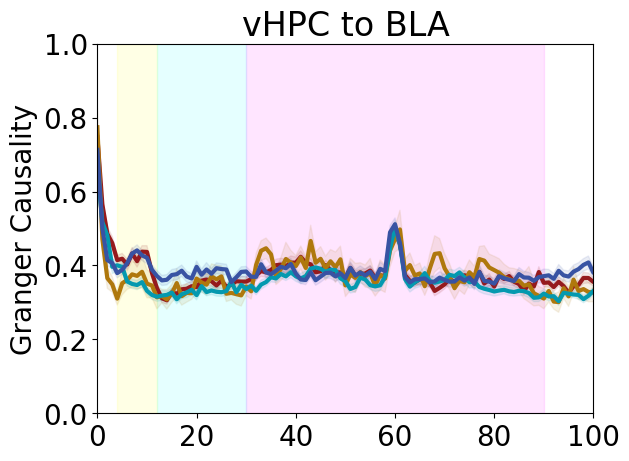

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


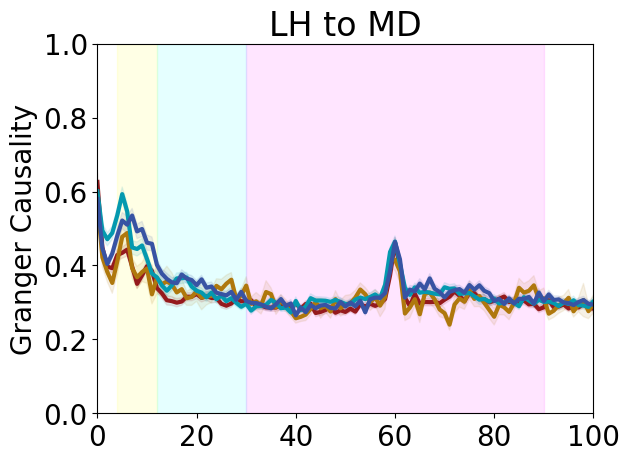

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


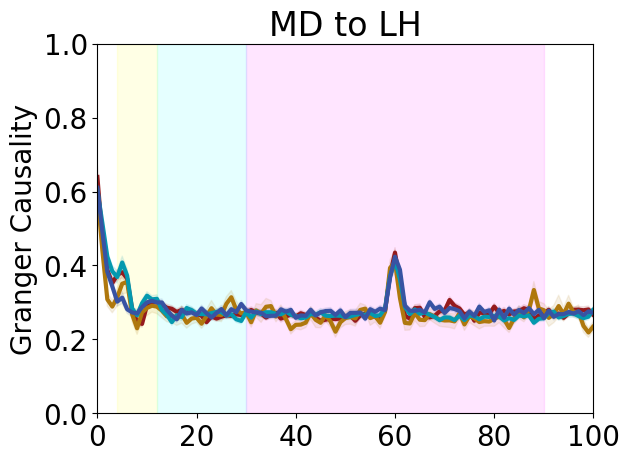

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


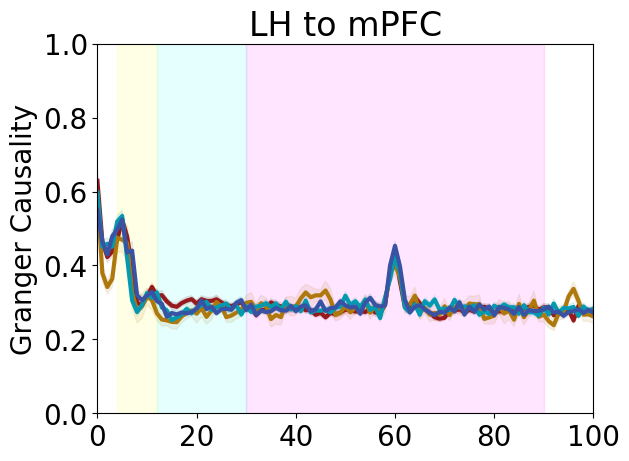

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


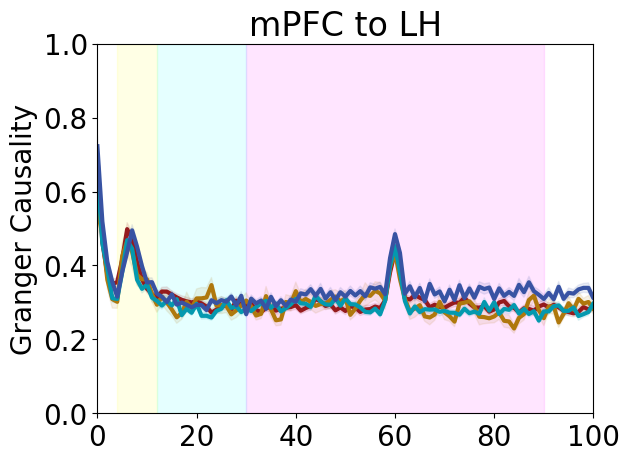

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


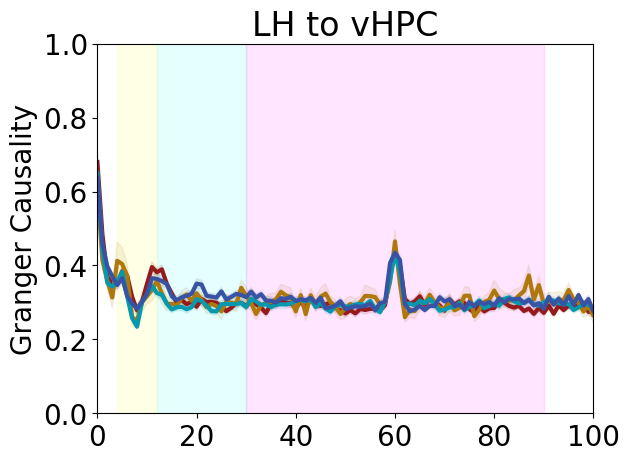

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


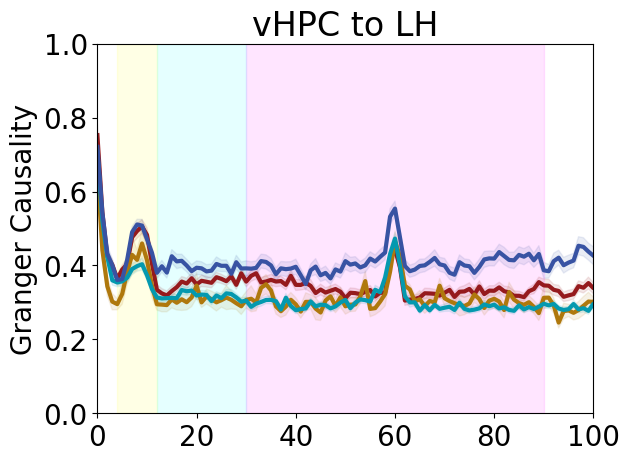

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


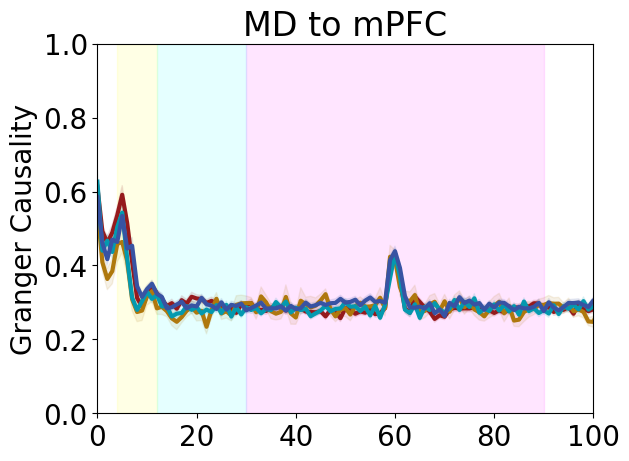

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


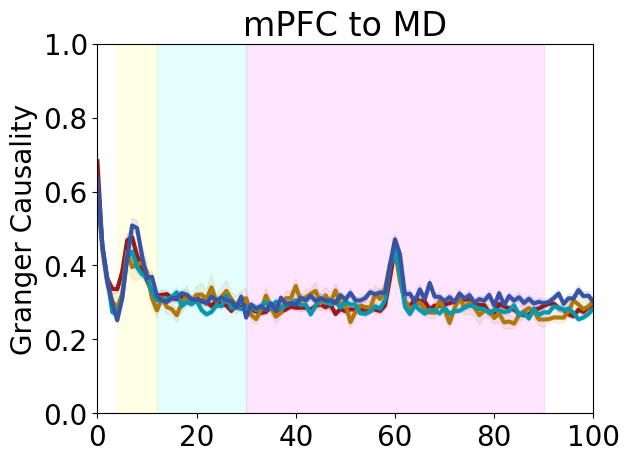

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


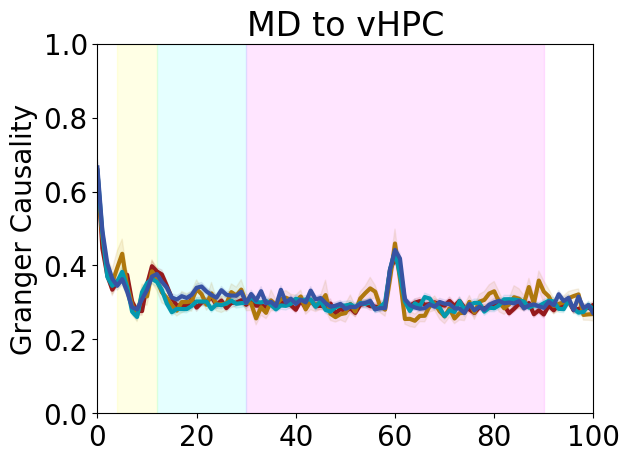

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


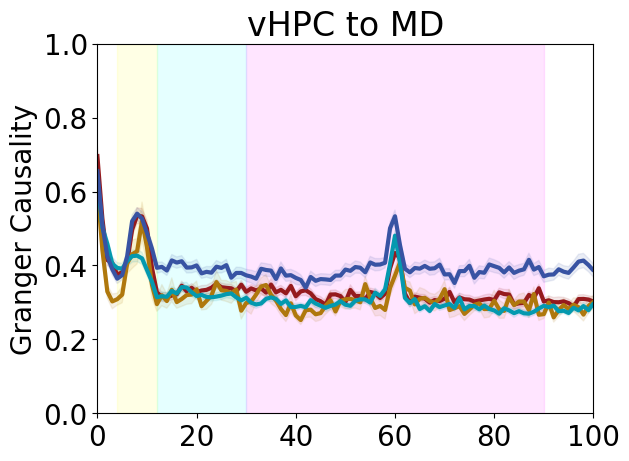

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


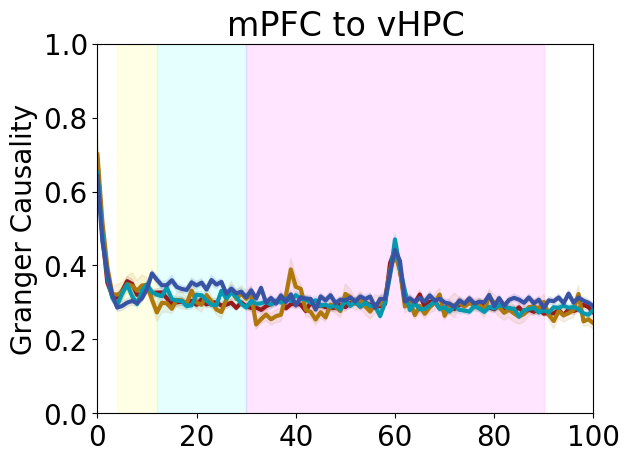

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


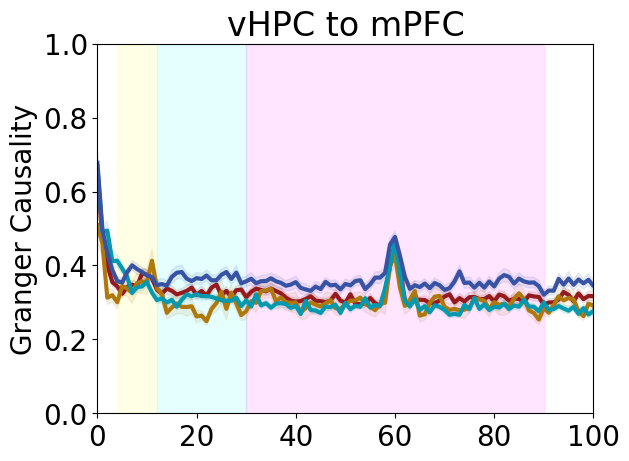

In [124]:
low_freq = 0
high_freq = 100

for region_1, region_2 in trial_brain_region_pairs:
    region_1_trimmed = region_1.split("_")[0]
    region_2_trimmed = region_2.split("_")[0]
    
    
    fig, ax = plt.subplots()
    plt.title("{} to {}".format(region_1_trimmed, region_2_trimmed))
    plt.xlim(low_freq, high_freq)
    plt.ylabel("Granger Causality")
    plt.ylim(0,1)

    ax.axvspan(4, 12, alpha=0.1, color='yellow', label="theta")
    ax.axvspan(12, 30, alpha=0.1, color='cyan', label="beta")
    ax.axvspan(30, 90, alpha=0.1, color='magenta', label="gamma")
    
    granger_col = "{}_{}_window_mean_granger".format(region_1_trimmed, region_2_trimmed)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)

    # plt.legend(ncol=3, loc="lower center")
    ax.get_legend().remove()

    plt.savefig("./proc/{}_{}_granger_{}_{}hz.png".format(region_1_trimmed, region_2_trimmed, low_freq, high_freq))
    plt.savefig("./proc/{}_{}_granger_{}_{}hz.eps".format(region_1_trimmed, region_2_trimmed, low_freq, high_freq))

    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("{} to {}".format(region_2_trimmed, region_1_trimmed))
    plt.xlim(low_freq, high_freq)
    plt.ylabel("Granger Causality")
    plt.ylim(0,1)

    ax.axvspan(4, 12, alpha=0.1, color='yellow', label="theta")
    ax.axvspan(12, 30, alpha=0.1, color='cyan', label="beta")
    ax.axvspan(30, 90, alpha=0.1, color='magenta', label="gamma")
    
    granger_col = "{}_{}_window_mean_granger".format(region_2_trimmed, region_1_trimmed)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)
    
    # plt.legend(ncol=3)
    ax.get_legend().remove()

    plt.savefig("./proc/granger/{}_{}_granger_{}_{}hz.png".format(region_2_trimmed, region_1_trimmed, low_freq, high_freq))
    plt.savefig("./proc/granger/{}_{}_granger_{}_{}hz.eps".format(region_2_trimmed, region_1_trimmed, low_freq, high_freq))

    plt.show()
    
    


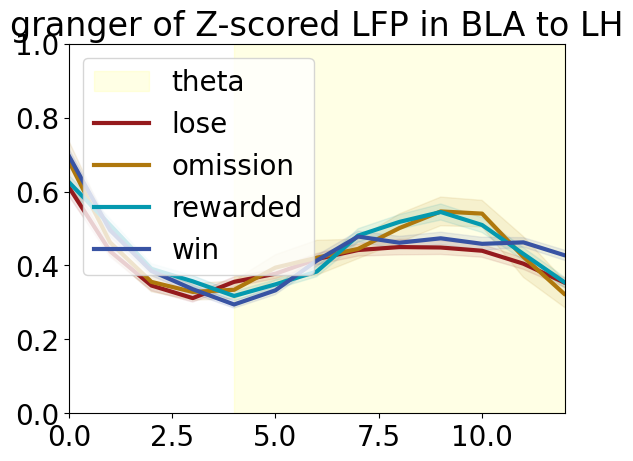

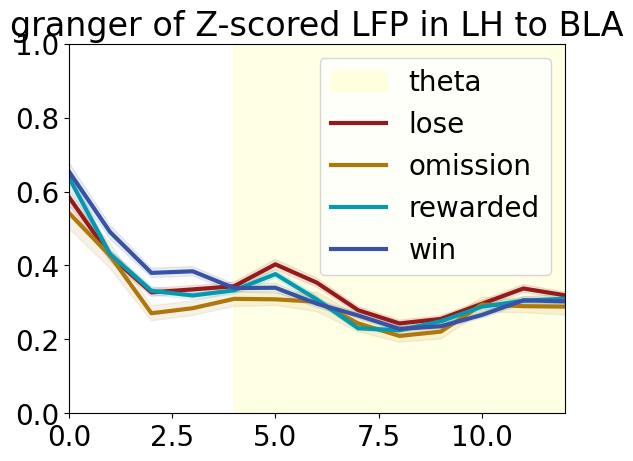

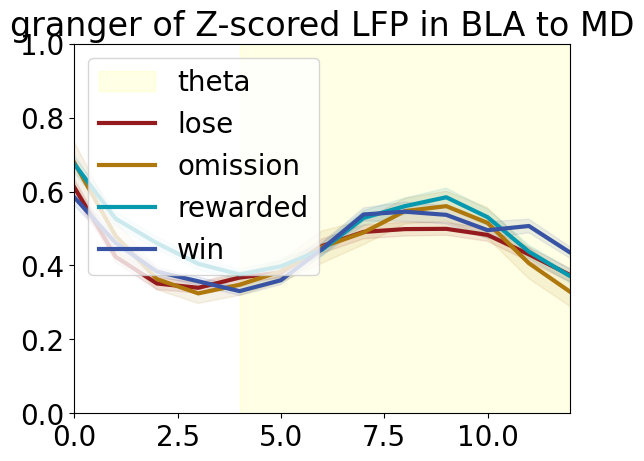

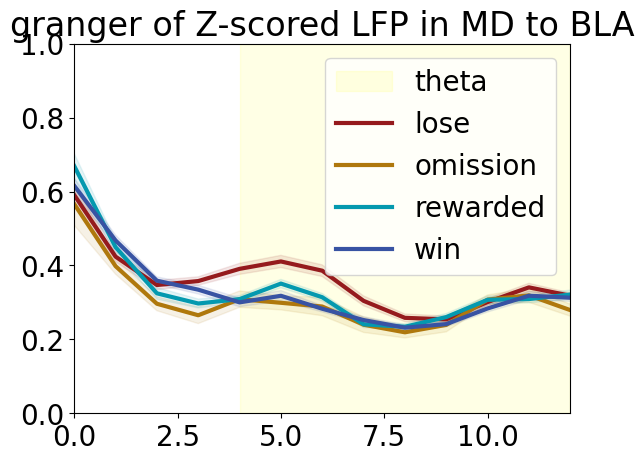

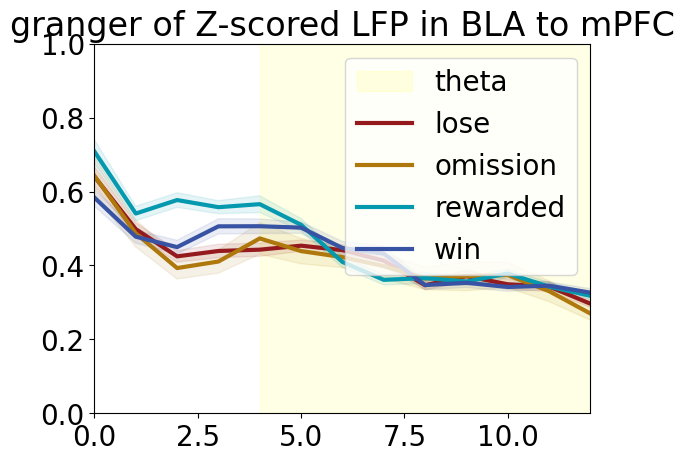

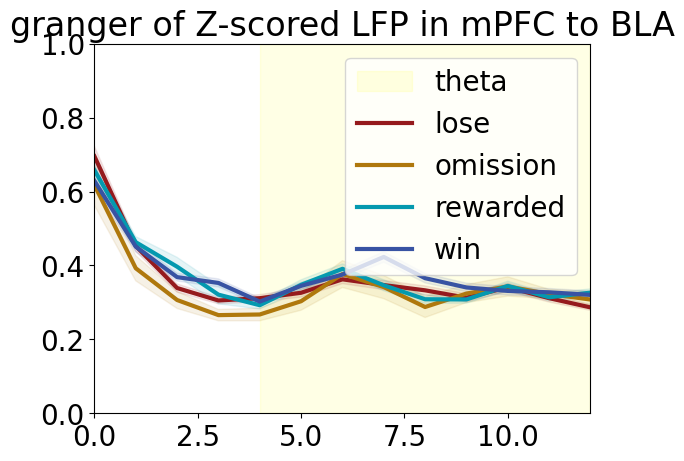

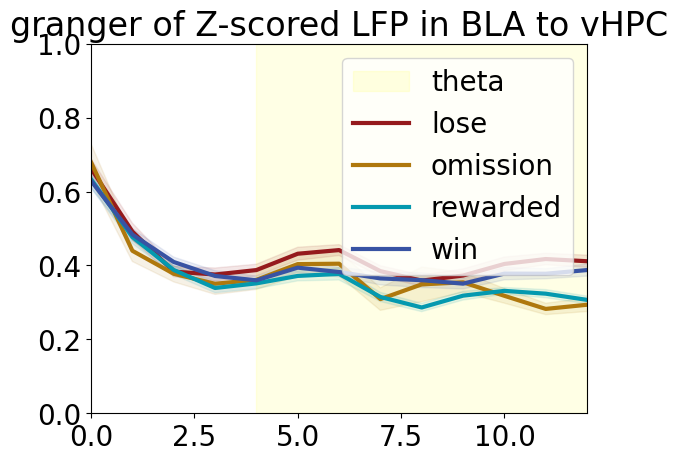

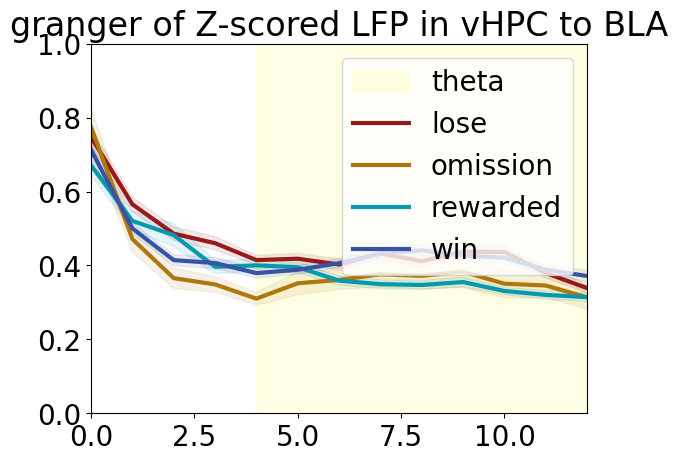

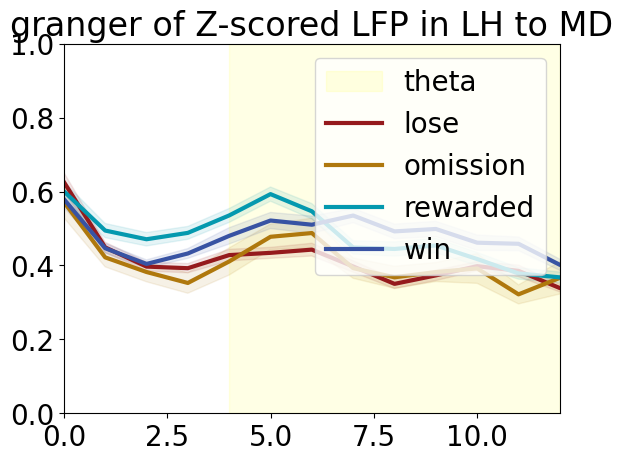

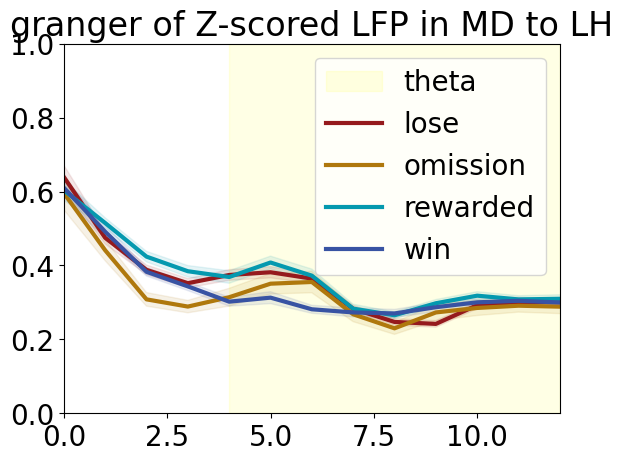

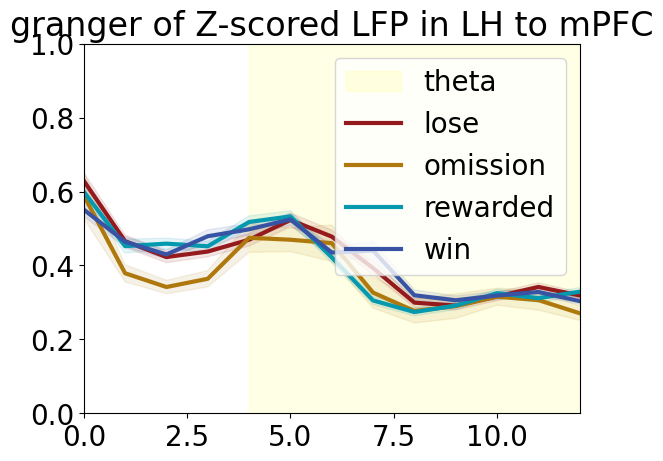

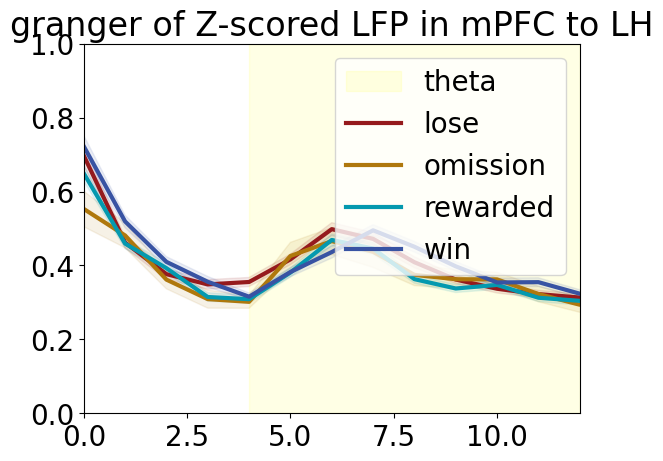

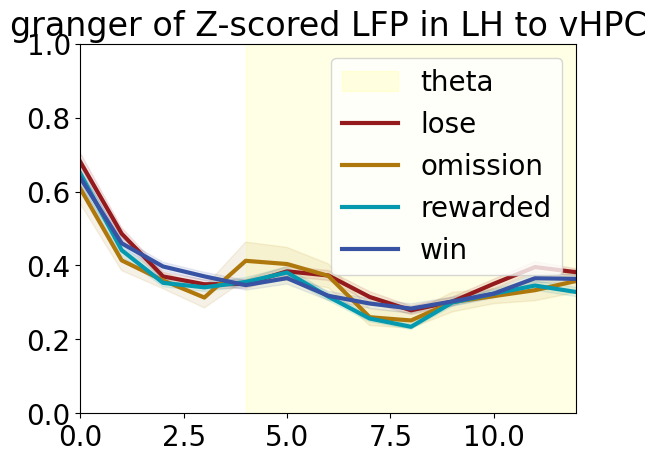

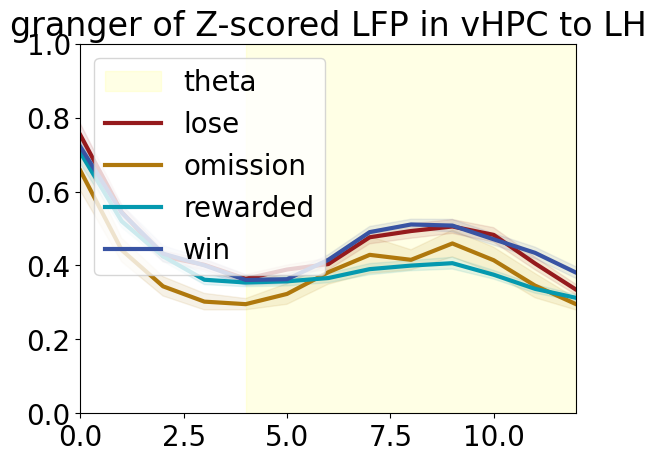

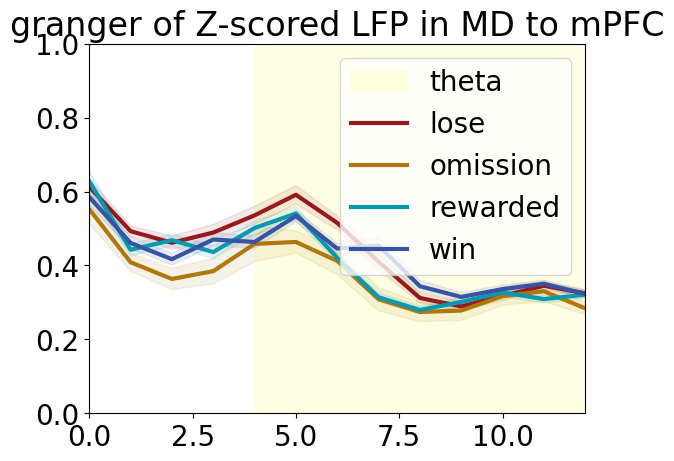

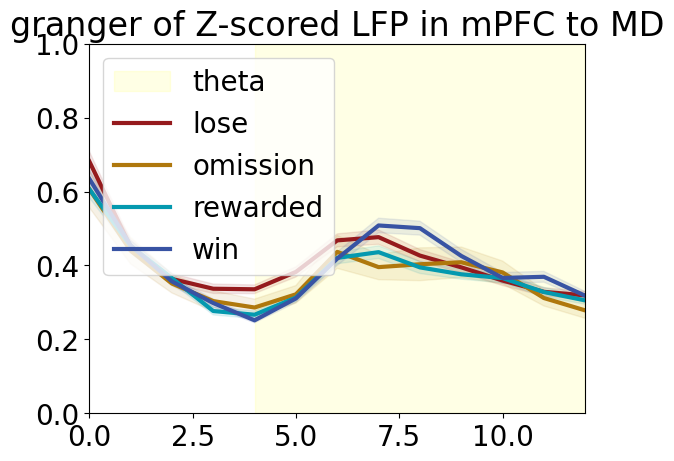

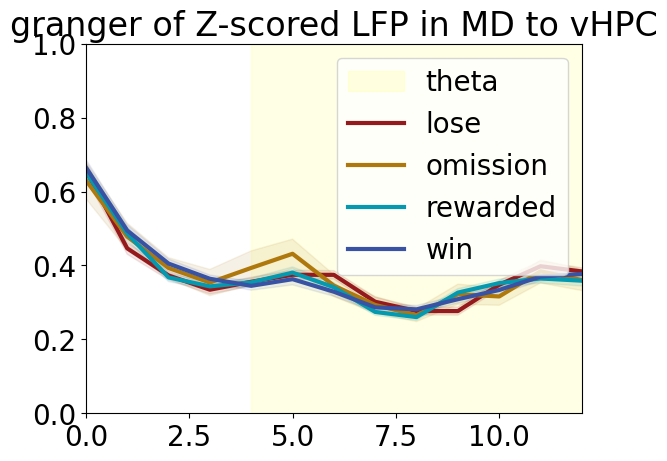

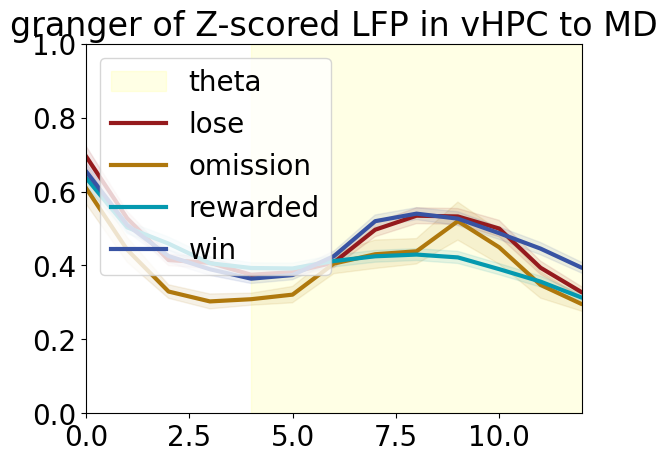

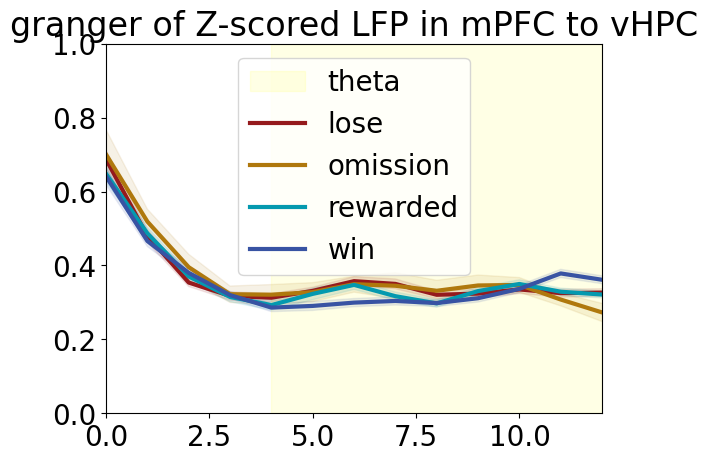

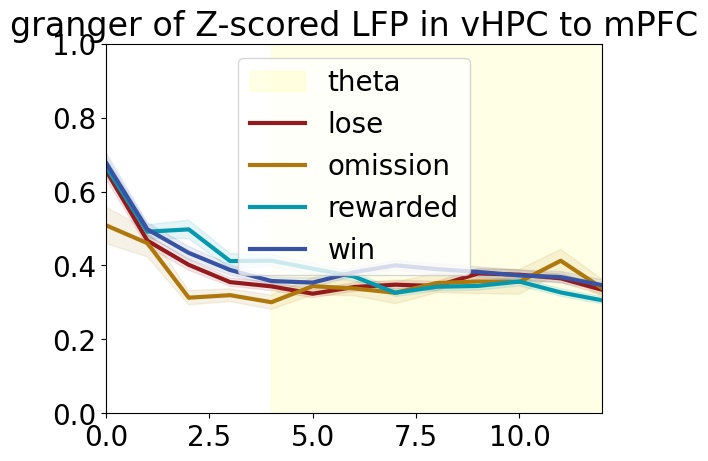

In [53]:
low_freq = 0
high_freq = 12

for region_1, region_2 in trial_brain_region_pairs:
    region_1_trimmed = region_1.split("_")[0]
    region_2_trimmed = region_2.split("_")[0]
    
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {} to {}".format(region_1_trimmed, region_2_trimmed))
    plt.xlim(low_freq, high_freq)
    plt.ylim(0,1)

    ax.axvspan(4, 12, alpha=0.1, color='yellow', label="theta")
    # ax.axvspan(12, 30, alpha=0.1, color='cyan', label="beta")
    # ax.axvspan(30, 90, alpha=0.1, color='magenta', label="gamma")
    
    granger_col = "{}_{}_window_mean_granger".format(region_1_trimmed, region_2_trimmed)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)

    # plt.legend(ncol=3, loc="lower center")

    plt.savefig("./proc/{}_{}_granger_{}_{}hz.png".format(region_1_trimmed, region_2_trimmed, low_freq, high_freq))
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {} to {}".format(region_2_trimmed, region_1_trimmed))
    plt.xlim(low_freq, high_freq)
    plt.ylim(0,1)

    ax.axvspan(4, 12, alpha=0.1, color='yellow', label="theta")
    
    granger_col = "{}_{}_window_mean_granger".format(region_2_trimmed, region_1_trimmed)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)
    
    # plt.legend(ncol=3, loc="lower center")

    plt.savefig("./proc/{}_{}_granger_{}_{}hz.png".format(region_2_trimmed, region_1_trimmed, low_freq, high_freq))

    plt.show()
    
    


# Filtering by band

# Filtering for each frequency band

In [54]:
MERGED_LFP_AND_SLEAP.columns

Index(['time', 'recording_file', 'video_number', 'current_subject',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baselineandtrial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baselineandtrial_lfp_trace',
       ...
       'MD_vHPC_trial_frequencies', 'MD_vHPC_split_windows_granger',
       'MD_vHPC_window_mean_granger', 'vHPC_MD_split_windows_granger',
       'vHPC_MD_window_mean_granger', 'mPFC_vHPC_trial_frequencies',
       'mPFC_vHPC_split_windows_granger', 'mPFC_vHPC_window_mean_granger',
       'vHPC_mPFC_split_windows_granger', 'vHPC_mPFC_window_mean_granger'],
      dtype='object', length=126)

In [55]:
window_mean_granger = [col for col in MERGED_LFP_AND_SLEAP if "window_mean_granger" in col]

In [56]:
window_mean_granger

['BLA_LH_window_mean_granger',
 'LH_BLA_window_mean_granger',
 'BLA_MD_window_mean_granger',
 'MD_BLA_window_mean_granger',
 'BLA_mPFC_window_mean_granger',
 'mPFC_BLA_window_mean_granger',
 'BLA_vHPC_window_mean_granger',
 'vHPC_BLA_window_mean_granger',
 'LH_MD_window_mean_granger',
 'MD_LH_window_mean_granger',
 'LH_mPFC_window_mean_granger',
 'mPFC_LH_window_mean_granger',
 'LH_vHPC_window_mean_granger',
 'vHPC_LH_window_mean_granger',
 'MD_mPFC_window_mean_granger',
 'mPFC_MD_window_mean_granger',
 'MD_vHPC_window_mean_granger',
 'vHPC_MD_window_mean_granger',
 'mPFC_vHPC_window_mean_granger',
 'vHPC_mPFC_window_mean_granger']

In [58]:
BAND_TO_FREQ

{'theta': (6, 11), 'gamma': (30, 51)}

In [59]:
for granger_column in window_mean_granger:
    region_1 = granger_column.split("_")[0]
    region_2 = granger_column.split("_")[1]

    for band, (low_freq, high_freq) in BAND_TO_FREQ.items():
        region_band_column = "{}_{}_{}_band_granger".format(region_1, region_2, band)
        print(region_band_column, low_freq, high_freq)
        MERGED_LFP_AND_SLEAP[region_band_column] = MERGED_LFP_AND_SLEAP[granger_column].apply(lambda x: np.mean(x[low_freq: high_freq]))

BLA_LH_theta_band_granger 6 11
BLA_LH_gamma_band_granger 30 51
LH_BLA_theta_band_granger 6 11
LH_BLA_gamma_band_granger 30 51
BLA_MD_theta_band_granger 6 11
BLA_MD_gamma_band_granger 30 51
MD_BLA_theta_band_granger 6 11
MD_BLA_gamma_band_granger 30 51
BLA_mPFC_theta_band_granger 6 11
BLA_mPFC_gamma_band_granger 30 51
mPFC_BLA_theta_band_granger 6 11
mPFC_BLA_gamma_band_granger 30 51
BLA_vHPC_theta_band_granger 6 11
BLA_vHPC_gamma_band_granger 30 51
vHPC_BLA_theta_band_granger 6 11
vHPC_BLA_gamma_band_granger 30 51
LH_MD_theta_band_granger 6 11
LH_MD_gamma_band_granger 30 51
MD_LH_theta_band_granger 6 11
MD_LH_gamma_band_granger 30 51
LH_mPFC_theta_band_granger 6 11
LH_mPFC_gamma_band_granger 30 51
mPFC_LH_theta_band_granger 6 11
mPFC_LH_gamma_band_granger 30 51
LH_vHPC_theta_band_granger 6 11
LH_vHPC_gamma_band_granger 30 51
vHPC_LH_theta_band_granger 6 11
vHPC_LH_gamma_band_granger 30 51
MD_mPFC_theta_band_granger 6 11
MD_mPFC_gamma_band_granger 30 51
mPFC_MD_theta_band_granger 6 11
m

In [60]:
MERGED_LFP_AND_SLEAP.head()

time                                     recording_file  video_number  \
0  30950500  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
1  32550496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
2  34350494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
3  35950496  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   
4  37450494  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1.0   

  current_subject                            mPFC_baseline_lfp_trace  \
0             6.1  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1             6.1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2             6.1  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3             6.1  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4             6.1  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                                mPFC_trial_lfp_trace  \
0  [0.50154364, 0.29617018, 0.22050627, 0.1145767...   
1  [0.31995025, 0.16429879, 0.010809131, 0.067016...   
2  [-0.13835686, 0.42804158, 0.5945022, 0.3134648...   
3  [-0.32211208, 0.023780087, 0.13835686, -0.1102...   
4  [-2.9508927, -2.998453, -2.3282866, -2.0104983...   

                     mPFC_baselineandtrial_lfp_trace  \
0  [-0.3134648, -0.39993784, -0.8777014, -1.44193...   
1  [1.1176641, 1.0657803, 0.9987637, 0.8128466, 0...   
2  [-0.22482991, 0.3567013, 0.12538591, -0.136195...   
3  [0.4864109, 0.18591705, 0.397776, 0.24212453, ...   
4  [-3.6210587, -2.9530544, -2.4342163, -2.574735...   

                             vHPC_baseline_lfp_trace  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...   

                                vHPC_trial_lfp_trace  \
0  [-1.1479185, -1.1806493, -1.1432426, -1.139735...   
1  [-1.0205019, -0.9152954, -0.9947847, -0.976081...   
2  [0.47109076, 0.34016728, 0.18352668, 0.174175,...   
3  [0.15780956, 0.047927346, -0.14728892, -0.3565...   
4  [-4.0457697, -4.2304654, -3.9113393, -3.448431...   

                     vHPC_baselineandtrial_lfp_trace  ...  \
0  [0.2583401, -0.26769176, -0.8311303, -1.046219...  ...   
1  [1.8691666, 2.0795794, 2.2408957, 2.3461022, 2...  ...   
2  [-1.0017985, -0.70955855, -0.7002069, -0.68033...  ...   
3  [0.58447987, 0.4675839, 0.21275067, 0.03389983...  ...   
4  [-1.4191171, -1.3793725, -1.1233703, -0.911788...  ...   

  mPFC_MD_theta_band_granger mPFC_MD_gamma_band_granger  \
0                   0.276419                   0.332952   
1                   0.269498                   0.294412   
2                   0.382133                   0.338950   
3                   0.355256                   0.317762   
4                   0.321499                   0.307658   

  MD_vHPC_theta_band_granger MD_vHPC_gamma_band_granger  \
0                   0.285580                   0.308700   
1                   0.412929                   0.296993   
2                   0.279211                   0.264659   
3                   0.343854                   0.336984   
4                   0.346098                   0.269036   

  vHPC_MD_theta_band_granger vHPC_MD_gamma_band_granger  \
0                   0.544461                   0.392972   
1                   0.424742                   0.484576   
2                   0.416857                   0.528551   
3                   0.406630                   0.504038   
4                   0.535375                   0.593945   

  mPFC_vHPC_theta_band_granger mPFC_vHPC_gamma_band_granger  \
0                     0.241112                     0.305378   
1                     0.337904                     0.328714   
2                     0.379768                     0.271932   
3                     0.235804                     0.310826  

In [61]:
BRAIN_REGIONS = ["spike_interface_mPFC",
"spike_interface_vHPC",
"spike_interface_BLA",
"spike_interface_LH",
"spike_interface_MD"]
for column in [col for col in MERGED_LFP_AND_SLEAP if "spike_interface" in col]:
    print(column)

spike_interface_mPFC
spike_interface_vHPC
spike_interface_BLA
spike_interface_LH
spike_interface_MD


In [62]:
band_window_mean_granger = [col for col in MERGED_LFP_AND_SLEAP if "band_granger" in col and "beta" not in col]

In [63]:
band_window_mean_granger

['BLA_LH_theta_band_granger',
 'BLA_LH_gamma_band_granger',
 'LH_BLA_theta_band_granger',
 'LH_BLA_gamma_band_granger',
 'BLA_MD_theta_band_granger',
 'BLA_MD_gamma_band_granger',
 'MD_BLA_theta_band_granger',
 'MD_BLA_gamma_band_granger',
 'BLA_mPFC_theta_band_granger',
 'BLA_mPFC_gamma_band_granger',
 'mPFC_BLA_theta_band_granger',
 'mPFC_BLA_gamma_band_granger',
 'BLA_vHPC_theta_band_granger',
 'BLA_vHPC_gamma_band_granger',
 'vHPC_BLA_theta_band_granger',
 'vHPC_BLA_gamma_band_granger',
 'LH_MD_theta_band_granger',
 'LH_MD_gamma_band_granger',
 'MD_LH_theta_band_granger',
 'MD_LH_gamma_band_granger',
 'LH_mPFC_theta_band_granger',
 'LH_mPFC_gamma_band_granger',
 'mPFC_LH_theta_band_granger',
 'mPFC_LH_gamma_band_granger',
 'LH_vHPC_theta_band_granger',
 'LH_vHPC_gamma_band_granger',
 'vHPC_LH_theta_band_granger',
 'vHPC_LH_gamma_band_granger',
 'MD_mPFC_theta_band_granger',
 'MD_mPFC_gamma_band_granger',
 'mPFC_MD_theta_band_granger',
 'mPFC_MD_gamma_band_granger',
 'MD_vHPC_theta_

In [64]:

from itertools import combinations

In [65]:
def get_significance_stars_from_p_value(p_value, number_of_comparisons=3):
    """
    """
    if p_value <= 0.001 / number_of_comparisons:
        return "***"
    elif p_value <= 0.01 / number_of_comparisons:
        return "***"
    elif p_value <= 0.05 / number_of_comparisons:
        return "*"
    else:
        return ""

In [66]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.dropna(subset=band_window_mean_granger).reset_index(drop=True)

In [67]:
region_and_band_to_mannwhitneyu = []
for col in band_window_mean_granger:
    brain_region = "_".join(col.split("_")[:2])
    band = col.split("_")[2]
    for first_outcome, second_outcome in combinations(sorted(MERGED_LFP_AND_SLEAP[GROUPINGS].unique()), 2):
        first_outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == first_outcome]
        second_outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == second_outcome]
        statistic, p_value = mannwhitneyu(first_outcome_df[col], second_outcome_df[col], alternative='two-sided')
        region_and_band_to_mannwhitneyu.append({"brain_region": brain_region, "band": band, "trial_outcome": (first_outcome, second_outcome), "statistic": statistic, "p_value": p_value})

In [68]:
mannwhitneyu(first_outcome_df[col].values, second_outcome_df[col].values, alternative='two-sided')

MannwhitneyuResult(statistic=2690.0, pvalue=0.0007540561935039624)

In [69]:
region_and_band_to_mannwhitneyu = pd.DataFrame(region_and_band_to_mannwhitneyu)

In [70]:
region_and_band_to_mannwhitneyu["significance"] = region_and_band_to_mannwhitneyu["p_value"].apply(lambda x: get_significance_stars_from_p_value(x))

In [71]:
region_and_band_to_mannwhitneyu = region_and_band_to_mannwhitneyu.sort_values(["band", "brain_region", "p_value"]).reset_index(drop=True)

In [72]:
region_and_band_to_mannwhitneyu

brain_region   band         trial_outcome  statistic   p_value  \
0         BLA_LH  gamma       (rewarded, win)     2475.0  0.000060   
1         BLA_LH  gamma      (lose, rewarded)     4126.0  0.018540   
2         BLA_LH  gamma           (lose, win)     3030.0  0.025382   
3         BLA_LH  gamma       (omission, win)      542.0  0.045475   
4         BLA_LH  gamma      (lose, omission)      784.0  0.422231   
..           ...    ...                   ...        ...       ...   
235    vHPC_mPFC  theta           (lose, win)     3086.0  0.038762   
236    vHPC_mPFC  theta       (omission, win)      584.0  0.099052   
237    vHPC_mPFC  theta      (lose, rewarded)     3568.0  0.591880   
238    vHPC_mPFC  theta      (lose, omission)      739.0  0.700207   
239    vHPC_mPFC  theta  (omission, rewarded)      696.0  0.934180   

    significance  
0            ***  
1                 
2                 
3                 
4                 
..           ...  
235               
236               
237               
238               
239               

[240 rows x 6 columns]

In [73]:
region_and_band_to_mannwhitneyu.sort_values("p_value")

brain_region   band     trial_outcome  statistic       p_value  \
222      vHPC_LH  theta   (rewarded, win)     1856.0  4.594183e-09   
216     vHPC_BLA  theta   (rewarded, win)     1999.0  5.512391e-08   
217     vHPC_BLA  theta  (lose, rewarded)     4972.0  3.190782e-07   
228      vHPC_MD  theta   (rewarded, win)     2195.0  1.245482e-06   
6         BLA_MD  gamma   (rewarded, win)     2296.0  5.455597e-06   
..           ...    ...               ...        ...           ...   
71       MD_vHPC  gamma  (lose, omission)      693.0  9.740946e-01   
131       BLA_MD  theta   (omission, win)      785.0  9.833419e-01   
191      MD_vHPC  theta   (rewarded, win)     3821.0  9.940396e-01   
137     BLA_mPFC  theta  (lose, omission)      698.0  9.962986e-01   
77      mPFC_BLA  gamma   (omission, win)      783.0  9.966682e-01   

    significance  
222          ***  
216          ***  
217          ***  
228          ***  
6            ***  
..           ...  
71                
131               
191               
137               
77                

[240 rows x 6 columns]

In [74]:
region_and_band_to_mannwhitneyu.to_csv("./proc/granger/granger_region_and_band_to_mannwhitneyu.csv")

In [77]:
BAND_TO_ALL_COL = {"theta": [], "gamma": []}

In [78]:
MERGED_LFP_AND_SLEAP.columns

Index(['time', 'recording_file', 'video_number', 'current_subject',
       'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baselineandtrial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baselineandtrial_lfp_trace',
       ...
       'mPFC_MD_theta_band_granger', 'mPFC_MD_gamma_band_granger',
       'MD_vHPC_theta_band_granger', 'MD_vHPC_gamma_band_granger',
       'vHPC_MD_theta_band_granger', 'vHPC_MD_gamma_band_granger',
       'mPFC_vHPC_theta_band_granger', 'mPFC_vHPC_gamma_band_granger',
       'vHPC_mPFC_theta_band_granger', 'vHPC_mPFC_gamma_band_granger'],
      dtype='object', length=166)

In [79]:
all_granger_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "window_mean_granger" in col]


In [80]:
all_granger_col

['BLA_LH_window_mean_granger',
 'LH_BLA_window_mean_granger',
 'BLA_MD_window_mean_granger',
 'MD_BLA_window_mean_granger',
 'BLA_mPFC_window_mean_granger',
 'mPFC_BLA_window_mean_granger',
 'BLA_vHPC_window_mean_granger',
 'vHPC_BLA_window_mean_granger',
 'LH_MD_window_mean_granger',
 'MD_LH_window_mean_granger',
 'LH_mPFC_window_mean_granger',
 'mPFC_LH_window_mean_granger',
 'LH_vHPC_window_mean_granger',
 'vHPC_LH_window_mean_granger',
 'MD_mPFC_window_mean_granger',
 'mPFC_MD_window_mean_granger',
 'MD_vHPC_window_mean_granger',
 'vHPC_MD_window_mean_granger',
 'mPFC_vHPC_window_mean_granger',
 'vHPC_mPFC_window_mean_granger']

In [105]:
for band, frequency in BAND_TO_FREQ.items():
    for col in all_granger_col:
        BAND_COL = "{}_averaged_{}_granger".format("_".join(col.split("_")[:2]), band)
        BAND_TO_ALL_COL[band].append(BAND_COL)
        print(BAND_COL)
        print(frequency[0], frequency[1])
        MERGED_LFP_AND_SLEAP[BAND_COL] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: np.nanmean(x[frequency[0]:frequency[1]]))    
        # MERGED_LFP_AND_SLEAP[BAND_COL] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: x[frequency[0]:frequency[1]])    


BLA_LH_averaged_theta_granger
6 11
LH_BLA_averaged_theta_granger
6 11
BLA_MD_averaged_theta_granger
6 11
MD_BLA_averaged_theta_granger
6 11
BLA_mPFC_averaged_theta_granger
6 11
mPFC_BLA_averaged_theta_granger
6 11
BLA_vHPC_averaged_theta_granger
6 11
vHPC_BLA_averaged_theta_granger
6 11
LH_MD_averaged_theta_granger
6 11
MD_LH_averaged_theta_granger
6 11
LH_mPFC_averaged_theta_granger
6 11
mPFC_LH_averaged_theta_granger
6 11
LH_vHPC_averaged_theta_granger
6 11
vHPC_LH_averaged_theta_granger
6 11
MD_mPFC_averaged_theta_granger
6 11
mPFC_MD_averaged_theta_granger
6 11
MD_vHPC_averaged_theta_granger
6 11
vHPC_MD_averaged_theta_granger
6 11
mPFC_vHPC_averaged_theta_granger
6 11
vHPC_mPFC_averaged_theta_granger
6 11
BLA_LH_averaged_gamma_granger
30 51
LH_BLA_averaged_gamma_granger
30 51
BLA_MD_averaged_gamma_granger
30 51
MD_BLA_averaged_gamma_granger
30 51
BLA_mPFC_averaged_gamma_granger
30 51
mPFC_BLA_averaged_gamma_granger
30 51
BLA_vHPC_averaged_gamma_granger
30 51
vHPC_BLA_averaged_gamm

In [112]:
region_pair_to_outcome_to_granger = {k: defaultdict(nested_dict) for k,v in BAND_TO_FREQ.items()}

for band, frequency in BAND_TO_FREQ.items():
    band_columns = [col for col in band_window_mean_granger if "band" in col and band in col]
    for outcome in MERGED_LFP_AND_SLEAP[GROUPINGS].unique():
        outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == outcome].copy()
        for band_col in band_columns:
            region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["mean"] = outcome_df[band_col].mean() 
            region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["sem"] = outcome_df[band_col].sem() 




In [113]:
region_pair_to_outcome_to_granger

{'theta': defaultdict(<function __main__.nested_dict()>,
             {'BLA_LH': defaultdict(dict,
                          {'win': {'mean': 0.45689456532161166,
                            'sem': 0.011976907231322493},
                           'lose': {'mean': 0.43935981467450946,
                            'sem': 0.013652979856662856},
                           'rewarded': {'mean': 0.4857048325825233,
                            'sem': 0.015148475159205433},
                           'omission': {'mean': 0.49059360082001585,
                            'sem': 0.029637243168347423}}),
              'LH_BLA': defaultdict(dict,
                          {'win': {'mean': 0.2582879434368144,
                            'sem': 0.00491156566077939},
                           'lose': {'mean': 0.28547253345505347,
                            'sem': 0.006994731094105712},
                           'rewarded': {'mean': 0.259770821031909,
                            'sem': 0.005586907031

In [114]:
group_name

'vHPC_mPFC'

In [120]:
region_and_band_to_mannwhitneyu.sort_values("p_value").head(n=25)

brain_region   band     trial_outcome  statistic       p_value  \
222      vHPC_LH  theta   (rewarded, win)     1856.0  4.594183e-09   
216     vHPC_BLA  theta   (rewarded, win)     1999.0  5.512391e-08   
217     vHPC_BLA  theta  (lose, rewarded)     4972.0  3.190782e-07   
228      vHPC_MD  theta   (rewarded, win)     2195.0  1.245482e-06   
6         BLA_MD  gamma   (rewarded, win)     2296.0  5.455597e-06   
223      vHPC_LH  theta  (lose, rewarded)     4767.0  8.842060e-06   
150        LH_MD  theta       (lose, win)     2347.0  1.749268e-05   
168       MD_BLA  theta       (lose, win)     5186.0  2.030230e-05   
102      vHPC_LH  gamma  (lose, rewarded)     4694.0  2.601602e-05   
138     BLA_vHPC  theta  (lose, rewarded)     4689.0  2.795639e-05   
18      BLA_vHPC  gamma   (rewarded, win)     2440.0  3.852260e-05   
0         BLA_LH  gamma   (rewarded, win)     2475.0  6.031334e-05   
229      vHPC_MD  theta  (lose, rewarded)     4499.0  3.565919e-04   
90     mPFC_vHPC  gamma       (lose, win)     2608.0  4.517967e-04   
108      vHPC_MD  gamma   (rewarded, win)     2671.0  6.127534e-04   
103      vHPC_LH  gamma   (rewarded, win)     2687.0  7.298978e-04   
114    vHPC_mPFC  gamma   (rewarded, win)     2690.0  7.540562e-04   
7         BLA_MD  gamma       (lose, win)     2670.0  8.972900e-04   
162      LH_vHPC  theta  (lose, rewarded)     4386.0  1.364706e-03   
151        LH_MD  theta  (lose, rewarded)     2428.0  1.493512e-03   
72      mPFC_BLA  gamma  (lose, rewarded)     2459.0  2.105656e-03   
12      BLA_mPFC  gamma   (rewarded, win)     2800.0  2.362365e-03   
180      MD_mPFC  theta   (rewarded, win)     2800.0  2.362365e-03   
169       MD_BLA  theta  (lose, rewarded)     4322.0  2.758567e-03   
19      BLA_vHPC  gamma  (lose, rewarded)     4304.0  3.337932e-03   

    significance  
222          ***  
216          ***  
217          ***  
228          ***  
6            ***  
223          ***  
150          ***  
168          ***  
102          ***  
138          ***  
18           ***  
0            ***  
229          ***  
90           ***  
108          ***  
103          ***  
114          ***  
7            ***  
162          ***  
151          ***  
72           ***  
12           ***  
180          ***  
169          ***  
19             *

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


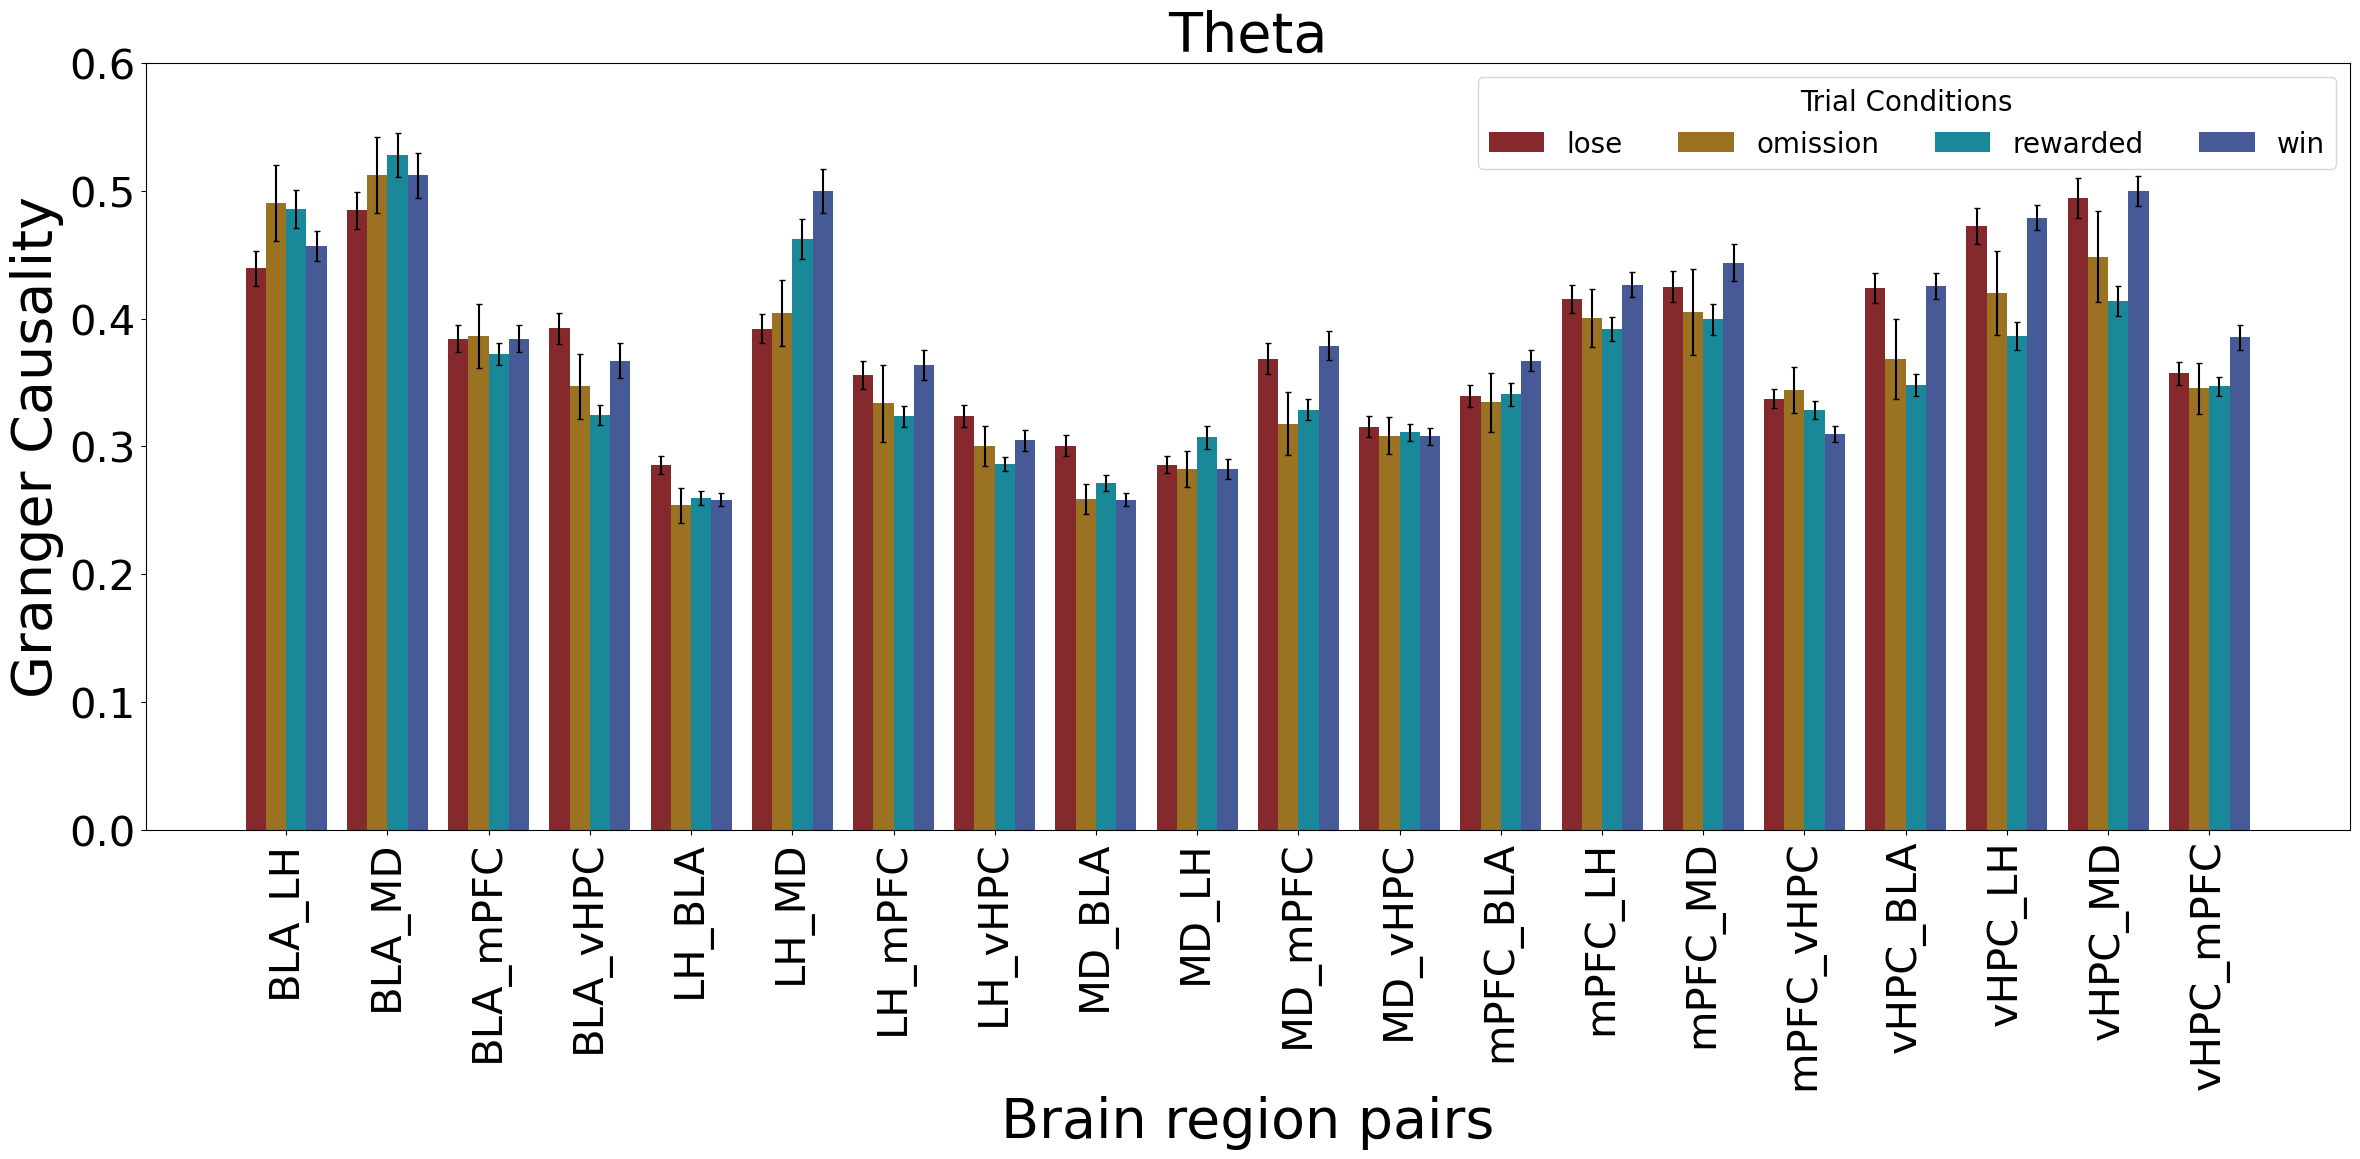

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


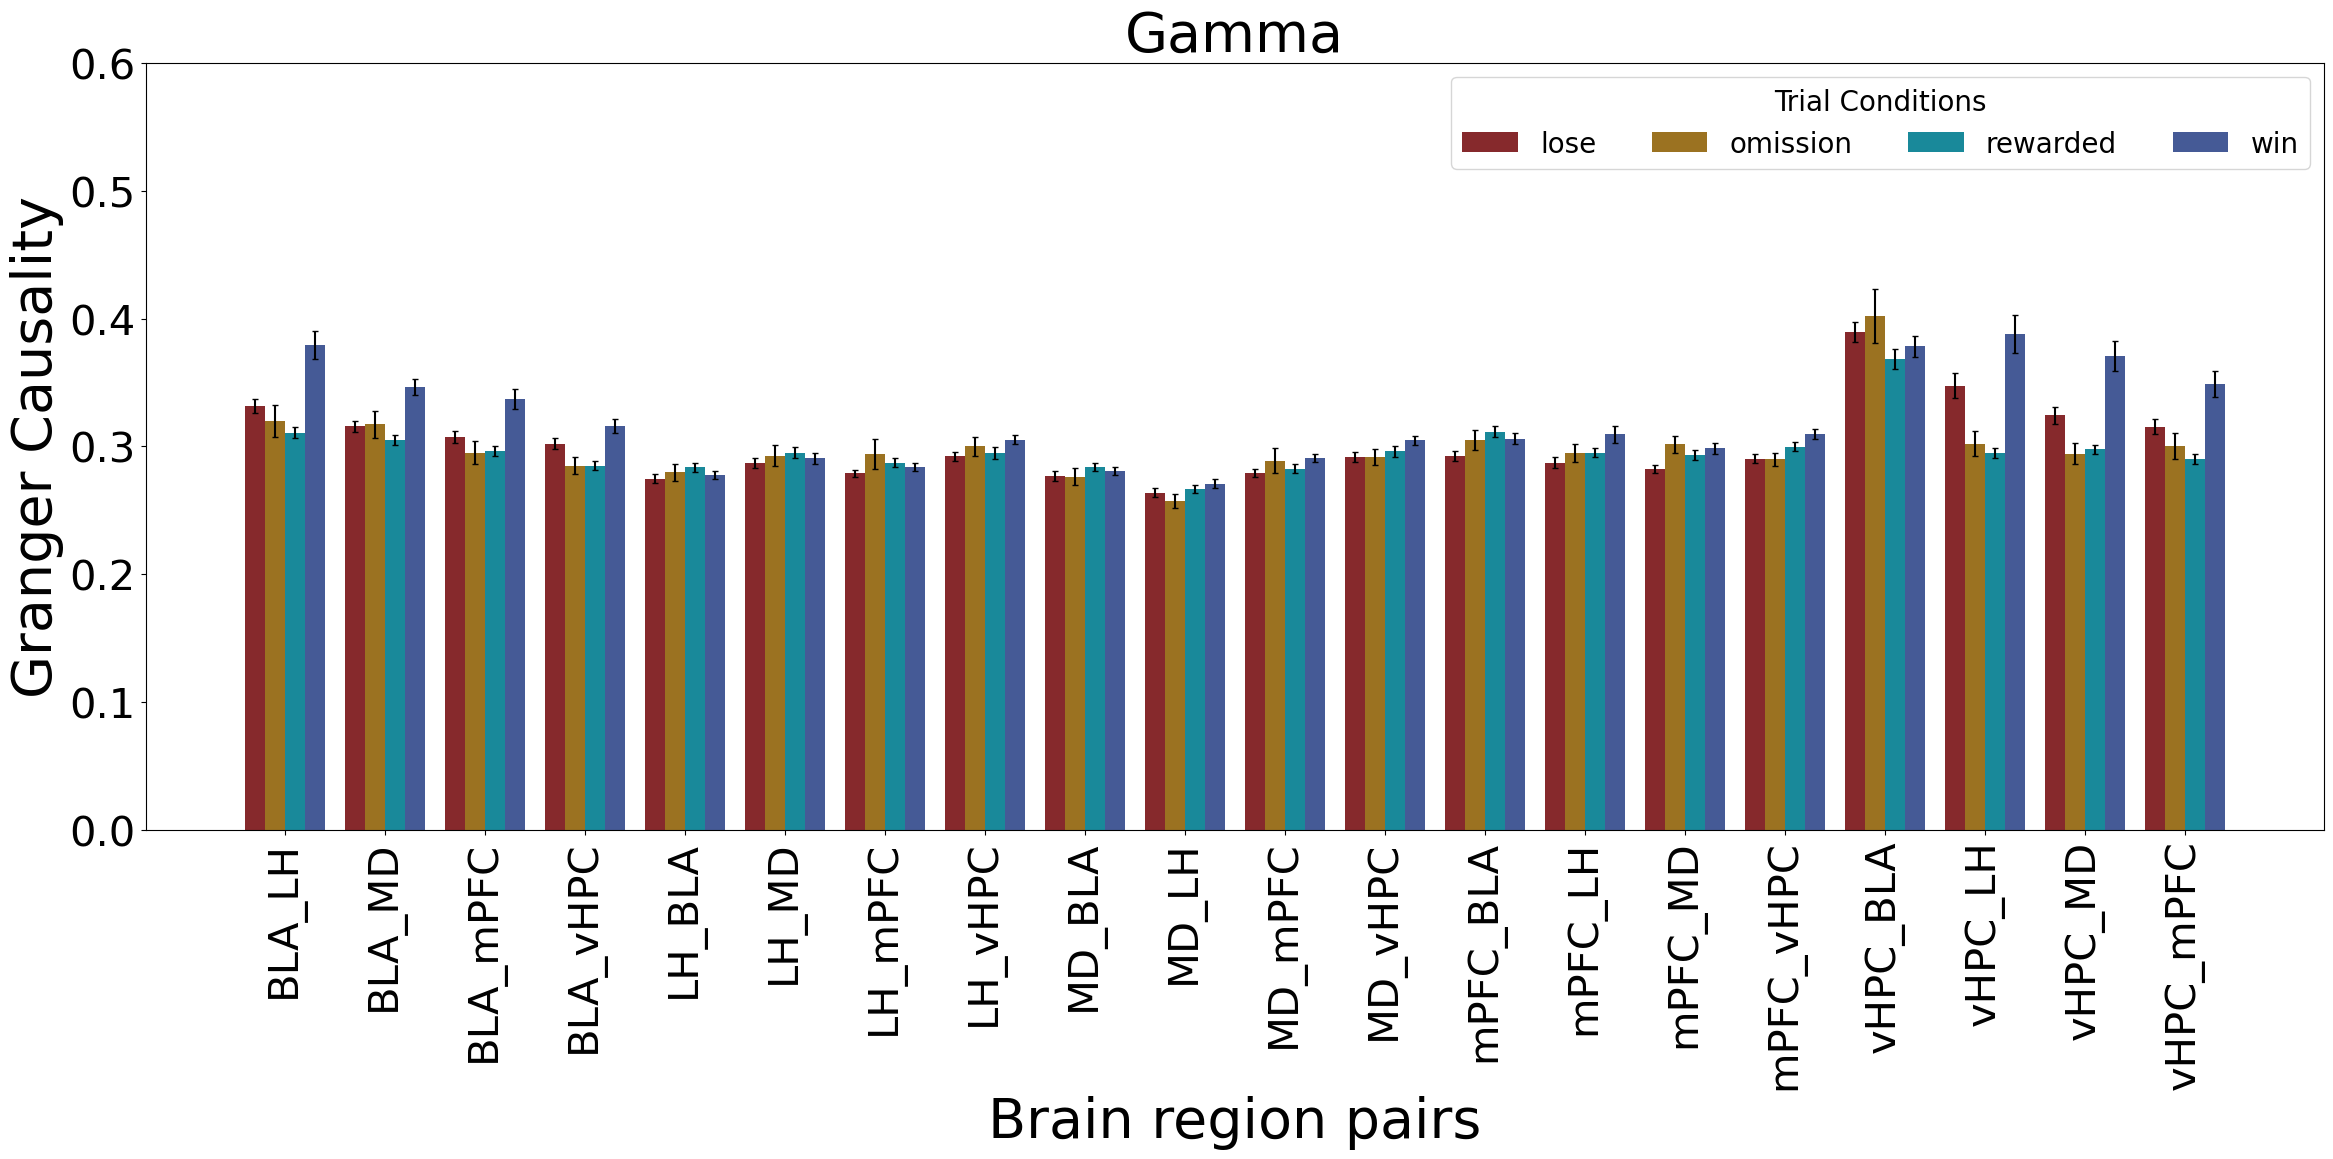

In [116]:
for band, frequency in BAND_TO_FREQ.items(): 
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in region_pair_to_outcome_to_granger[band].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "granger": bar_dict["mean"], "sem": bar_dict["sem"]})
    df = pd.DataFrame(data).sort_values(by=["Group", "Bar"])
    df["color"] = df["Bar"].map(OUTCOME_TO_COLOR)    
    fig, ax = plt.subplots(figsize=(24,12))
    
    
    # Create barplot
    ax = sns.barplot(x='Group', y='granger', hue='Bar', data=df, palette=df["color"].to_numpy(), ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group  # the width of the bars
    x_positions = []  # this will store the x positions for the error bars

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]  # filter the dataframe for the specific group
        num_bars = group_data.shape[0]  # get the number of bars for this group
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)  # add these positions to the list

        for pos, (idx, row) in zip(group_positions, group_data.iterrows()):
            height = row['granger']
            error = row['sem']
            plt.errorbar(pos, height, yerr=error, color='black', capsize=2, fmt='none', zorder=10)
    
    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel("Brain region pairs", fontsize=40)
    plt.ylabel("Granger Causality".format(band.title()), fontsize=40)
    plt.legend(title="Trial Conditions", ncol=4)
    plt.title("{}".format(band.title()), fontsize=40)
    plt.tight_layout()
    # plt.grid()
    plt.ylim(0,0.6)
    # ax.get_legend().remove()

    plt.savefig("./proc/granger/all_zscored_{}_lfp_granger.png".format(band))
    plt.savefig("./proc/granger/all_zscored_{}_lfp_granger.eps".format(band))

    # Show the plot
    plt.show()

In [ ]:
raise ValueError()

In [ ]:
mean_granger_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_window_mean_granger].mean()
sem_granger_df = MERGED_LFP_AND_SLEAP.groupby(GROUPINGS)[band_window_mean_granger].sem()

for column in band_window_mean_granger:
    fig, ax = plt.subplots(figsize=(23, 12))

    brain_region = column.split("_")[0]
    band = column.split("_")[1]
    plt.title("granger of {} {} Band".format(brain_region, band.capitalize()), fontsize=80)
    plt.ylabel("granger (a.u.)", fontsize=80)
    bars = plt.bar(mean_granger_df.index, mean_granger_df[column], color=mean_granger_df.index.map(OUTCOME_TO_COLOR))
    
    plt.errorbar(mean_granger_df.index, mean_granger_df[column],
        yerr=sem_granger_df[column],
        color='k',
        capsize=30,
        linestyle='None',
        elinewidth=7,
        capthick=7)
    
    plt.ylim(0, BAND_TO_YLIM[band])
    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)
    plt.locator_params(axis='y', nbins=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig("./proc/velocity_parsed_granger/bar_plots/{}_{}_velocity_parsed_lfp_granger_bar.eps".format(band, brain_region)) #nancy changed png to eps
    plt.savefig("./proc/velocity_parsed_granger/bar_plots/{}_{}_velocity_parsed_lfp_granger_bar.png".format(band, brain_region)) #nancy changed png to eps


In [ ]:
MERGED_LFP_AND_SLEAP

# Network Predictivity

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
feature_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged" in col and ("granger" in col or "coherence" in col)]
feature_columns = [col for col in feature_columns if "beta" not in col]

In [ ]:
feature_columns

- Filtering out for trials that are win vs loss

In [ ]:
network_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"].isin(["win", "lose", "rewarded"])]
network_df = network_df.dropna(subset="mPFC_MD_averaged_gamma_granger")

In [ ]:
network_df.groupby("trial_outcome").count()

In [ ]:
network_array = network_df[feature_columns].values

In [ ]:
network_df.head()

In [ ]:
original_scores=[]
kFold=KFold(n_splits=5,shuffle=True)


all_predictions = []
all_labels = []

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 100)

for train_index, test_index in kFold.split(network_array):
    
    X_train = network_array[train_index]  
    X_test = network_array[test_index]
    y_train = network_df["trial_outcome"].values[train_index]
    y_test = network_df["trial_outcome"].values[test_index]

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 
    all_predictions += clf.predict(X_test).tolist()
    all_labels += y_test.tolist()
    
    original_scores.append(clf.score(X_test,y_test))
mean_original_scores = np.mean(original_scores)
# 0.9393939393939394


In [ ]:
len(train_index)

In [ ]:
len(network_df)

In [ ]:
original_scores

In [ ]:
y_test

In [ ]:
clf.predict(X_test)

In [ ]:
OUTCOME_LABELS=["win", "lose", "rewarded"]

In [ ]:
#compute the confusion matrix.
# cm = confusion_matrix(clf.predict(X_test),y_test, labels=OUTCOME_LABELS)
cm = confusion_matrix(all_predictions,all_labels, labels=OUTCOME_LABELS)


#Plot the confusion matrix.
sns.heatmap(cm/sum(cm), 
            annot=True,
            # fmt='g', 
            fmt='.2%',
           cmap="Blues", xticklabels=OUTCOME_LABELS, yticklabels=OUTCOME_LABELS)
# sns.light_palette("seagreen", as_cmap=True)

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Random Forest of\nCoherence and Granger's Causality",fontsize=17)
plt.savefig("./proc/rf_original_connectivity_confusion_matrix.png")

plt.show()

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [ ]:
std

In [ ]:
forest_importances = pd.DataFrame(importances, index=feature_columns).sort_values(0, ascending=False).reset_index()
forest_importances = forest_importances.rename(columns={0: "mdi"})

In [ ]:
forest_importances["index"]

In [ ]:
forest_importances["brain_regions"] = forest_importances["index"].apply(lambda x: x.split("_")[:2])
forest_importances["measure"] = forest_importances["index"].apply(lambda x: x.split("_")[-1])
forest_importances["band"] = forest_importances["index"].apply(lambda x: x.split("_")[-2])

In [ ]:
forest_importances = forest_importances.iloc[:10]

In [ ]:
forest_importances["color"] = forest_importances["band"].map(BAND_TO_COLOR)
forest_importances["pattern"] = forest_importances["measure"].map(MEASURE_TO_PATTERN)

In [ ]:
forest_importances["index"] = forest_importances["index"].apply(lambda x: " ".join([_.strip("_") for _ in x.split("averaged")]))

In [ ]:
forest_importances

In [ ]:
for index, row in forest_importances.iterrows():
    plt.bar(row["index"], row["mdi"], color=row["color"], label="{} {}".format(row["band"], row["measure"]), hatch=row["pattern"])

plt.xticks(fontsize=10, rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Feature importances for winning/losing", fontsize=20)
plt.ylabel("Mean decrease in impurity", fontsize=20)
# plt.tight_layout()
plt.savefig("./proc/network/rf_connectivity_feature_importance.png")
plt.show()

- Shuffling the labels

In [ ]:
shuffled_scores=[]
kFold=KFold(n_splits=5,shuffle=True)


all_predictions = []
all_labels = []

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 100)

for train_index, test_index in kFold.split(network_array):
    
    X_train = network_array[train_index]  
    X_test = network_array[test_index]
    y_train = shuffle(network_df["trial_outcome"].values[train_index])
    y_test = network_df["trial_outcome"].values[test_index]

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 
    all_predictions += clf.predict(X_test).tolist()
    all_labels += y_test.tolist()
    
    shuffled_scores.append(clf.score(X_test,y_test))
mean_shuffled_scores = np.mean(shuffled_scores)
# 0.9393939393939394


In [ ]:
shuffled_scores

In [ ]:
y_test

In [ ]:
clf.predict(X_test)

In [ ]:
clf.predict(X_test),y_test

In [ ]:
#compute the confusion matrix.
# cm = confusion_matrix(clf.predict(X_test),y_test, labels=OUTCOME_LABELS)
cm = confusion_matrix(all_predictions,all_labels, labels=OUTCOME_LABELS)


#Plot the confusion matrix.
sns.heatmap(cm/sum(cm), 
            annot=True,
            # fmt='g', 
            fmt='.2%',
           cmap="Blues", xticklabels=OUTCOME_LABELS, yticklabels=OUTCOME_LABELS)
# sns.light_palette("seagreen", as_cmap=True)

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Random forest of shuffled connectivity',fontsize=17)
plt.savefig("./proc/rf_shuffled_connectivity_confusion_matrix.png")

plt.show()

In [ ]:
shuffled_scores

In [ ]:
original_scores

In [ ]:
plt.bar(x=["Granger and Coherence", "Shuffled"], height=[np.mean(original_scores), np.mean(shuffled_scores)], color= ["#FFAF00", "#15616F"])
plt.ylabel("Accuracy", fontsize=20)
plt.title("Random Forest Connectivity Accuracy", fontsize=20)
plt.errorbar(["Granger and Coherence", "Shuffled"], [np.mean(original_scores), np.mean(shuffled_scores)], yerr=[stats.sem(original_scores), stats.sem(shuffled_scores)], fmt="o", color="black", capsize=10)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("./proc/rf_connectivity_predictions_score.png")

In [ ]:
raise ValueError()

In [ ]:
# Simulate signal
frequency_of_interest = [200, 50]
sampling_frequency = 1500
time_extent = (0, 50)
n_time_samples = ((time_extent[1] - time_extent[0]) * sampling_frequency) + 1
time = np.linspace(time_extent[0], time_extent[1], num=n_time_samples, endpoint=True)
signal = np.sin(2 * np.pi * time[:, np.newaxis] * frequency_of_interest)
signal[: n_time_samples // 2, 1] = 0
signal = signal.sum(axis=1)
noise = np.random.normal(0, 4, signal.shape)

# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
axes[0, 0].plot(time, signal)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].set_title("Signal", fontweight="bold")
axes[0, 0].set_xlim((24.90, 25.10))
axes[0, 0].set_ylim((-10, 10))

axes[0, 1].plot(time, signal + noise)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Amplitude")
axes[0, 1].set_title("Signal + Noise", fontweight="bold")
axes[0, 1].set_xlim((24.90, 25.10))
axes[0, 1].set_ylim((-10, 10))

multitaper = Multitaper(
    signal,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
axes[1, 0].plot(connectivity.frequencies, connectivity.granger().squeeze())
axes[1, 0].set_xlabel("Frequency")
axes[1, 0].set_ylabel("granger")

multitaper = Multitaper(
    signal + noise,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
axes[1, 1].plot(connectivity.frequencies, connectivity.granger().squeeze())
axes[1, 1].set_xlabel("Frequency")
axes[1, 1].set_ylabel("granger")


multitaper = Multitaper(
    signal,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=0.600,
    time_window_step=0.300,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
mesh = axes[2, 0].pcolormesh(
    connectivity.time,
    connectivity.frequencies,
    connectivity.granger().squeeze().T,
    vmin=0.0,
    vmax=0.03,
    cmap="viridis",
    shading="auto",
)
axes[2, 0].set_ylim((0, 300))
axes[2, 0].axvline(time[int(np.fix(n_time_samples / 2))], color="black")
axes[2, 0].set_ylabel("Frequency")
axes[2, 0].set_xlabel("Time")

multitaper = Multitaper(
    signal + noise,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=0.600,
    time_window_step=0.300,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
mesh = axes[2, 1].pcolormesh(
    connectivity.time,
    connectivity.frequencies,
    connectivity.granger().squeeze().T,
    vmin=0.0,
    vmax=0.03,
    cmap="viridis",
    shading="auto",
)
axes[2, 1].set_ylim((0, 300))
axes[2, 1].axvline(time[int(np.fix(n_time_samples / 2))], color="black")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].set_xlabel("Time")

plt.tight_layout()
cb = fig.colorbar(
    mesh,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    shrink=0.5,
    aspect=15,
    pad=0.1,
    label="granger",
)
cb.outline.set_linewidth(0)


In [ ]:
BAND_TO_ALL_COL = {"theta": [], "beta": [], "gamma": []}

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
all_granger_col = [col for col in MERGED_LFP_AND_SLEAP.columns if "window_mean_granger" in col]


In [ ]:
all_granger_col

In [ ]:
for band, frequency in BAND_TO_FREQ.items():
    for col in all_granger_col:
        BAND_COL = "{}_averaged_{}_granger".format("_".join(col.split("_")[:2]), band)
        BAND_TO_ALL_COL[band].append(BAND_COL)
        print(BAND_COL)
        print(frequency[0], frequency[1])
        MERGED_LFP_AND_SLEAP[BAND_COL] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: np.nanmean(x[frequency[0]:frequency[1]]))    
        # MERGED_LFP_AND_SLEAP[BAND_COL] = MERGED_LFP_AND_SLEAP[col].apply(lambda x: x[frequency[0]:frequency[1]])    


In [ ]:
MERGED_LFP_AND_SLEAP["BLA_LH_averaged_theta_granger"].iloc[0]

In [ ]:
MERGED_LFP_AND_SLEAP[col].iloc[0].shape

In [ ]:
MERGED_LFP_AND_SLEAP[GROUPINGS].unique()

In [ ]:
region_pair_to_outcome_to_granger = {k: defaultdict(nested_dict) for k,v in BAND_TO_FREQ.items()}

for band, frequency in BAND_TO_FREQ.items():
    for outcome in MERGED_LFP_AND_SLEAP[GROUPINGS].unique():
        outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == outcome].copy()
        for band_col in set(BAND_TO_ALL_COL[band]):
            region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["mean"] = outcome_df[band_col].mean() 
            region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["sem"] = outcome_df[band_col].sem() 




In [ ]:
BAND_TO_ALL_COL[band]

In [ ]:
import matplotlib

In [ ]:
font = {'weight' : 'bold',
        'size'   : 36}

matplotlib.rc('font', **font)

In [ ]:
for band, frequency in BAND_TO_FREQ.items(): 
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in region_pair_to_outcome_to_granger[band].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "granger": bar_dict["mean"], "sem": bar_dict["sem"]})
    df = pd.DataFrame(data).sort_values(by=["Group", "Bar"])
    df["color"] = df["Bar"].map(OUTCOME_TO_COLOR)    
    fig, ax = plt.subplots(figsize=(24,12))
    
    
    # Create barplot
    ax = sns.barplot(x='Group', y='granger', hue='Bar', data=df, palette=df["color"], ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group  # the width of the bars
    x_positions = []  # this will store the x positions for the error bars

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]  # filter the dataframe for the specific group
        num_bars = group_data.shape[0]  # get the number of bars for this group
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)  # add these positions to the list

        for pos, (idx, row) in zip(group_positions, group_data.iterrows()):
            height = row['granger']
            error = row['sem']
            plt.errorbar(pos, height, yerr=error, color='black', capsize=2, fmt='none', zorder=10)
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs", fontsize=40)
    plt.ylabel("{} granger".format(band.title()), fontsize=40)
    plt.legend(title="Trial Conditions", loc="lower left", ncol=4)
    plt.title("{} granger".format(band.title()), fontsize=40)
    plt.tight_layout()
    plt.grid()
    plt.ylim(0,0.5)
    # ax.get_legend().remove()

    plt.savefig("./proc/granger/all_zscored_{}_lfp_granger_granger.png".format(band))
    # Show the plot
    plt.show()

In [ ]:
trial_outcome_pairs = ("win", "lose"), ("win", "rewarded"), ("lose", "omission")

In [ ]:
for band, frequency in BAND_TO_FREQ.items():
    print(band)

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
MERGED_LFP_AND_SLEAP["trial_outcome"].unique()

In [ ]:
region_to_mannwhitneyu = defaultdict(dict)
region_to_mannwhitneyu = []

for band, frequency in BAND_TO_FREQ.items():
    print(band)
    for region_col in [col for col in MERGED_LFP_AND_SLEAP.columns if band in col]:
        print(region_col)  
        for outcome_pair in trial_outcome_pairs:
            outcome_1_granger = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == outcome_pair[0]][region_col].dropna()
            outcome_2_granger = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"] == outcome_pair[1]][region_col].dropna()
            statistic, p_value = mannwhitneyu(outcome_1_granger, outcome_2_granger, alternative='two-sided')
            region_to_mannwhitneyu.append({"band": band, "region": region_col, "p_value": p_value, "statistic": statistic, "outcome": outcome_pair})
            
            # region_to_mannwhitneyu[region_col][outcome_pair] = p_value
            # print(region_col)
    
    
    # for outcome in MERGED_LFP_AND_SLEAP[GROUPINGS].unique():
    #     outcome_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP[GROUPINGS] == outcome].copy()
    #     for band_col in BAND_TO_ALL_COL[band]:
    #         region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["mean"] = outcome_df[band_col].mean() 
    #         region_pair_to_outcome_to_granger[band]["_".join(band_col.split("_")[:-3])][outcome]["sem"] = outcome_df[band_col].sem() 




In [ ]:
granger_mannwhitneyu = pd.DataFrame(region_to_mannwhitneyu)

In [ ]:
granger_mannwhitneyu[granger_mannwhitneyu["p_value"] <= 0.001/3].sort_values(["p_value", "region"], ascending=True)

In [ ]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.drop(columns="functional_graph", errors="ignore")

In [ ]:
MERGED_LFP_AND_SLEAP.to_pickle("./proc/MERGED_LFP_AND_SLEAP.pkl")

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
for col in MERGED_LFP_AND_SLEAP:
    print(col)

# Network Analysis

In [ ]:
raise ValueError()

In [ ]:
feature_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged" in col and "coherence" in col or "averaged" in col and "granger" in col]

In [ ]:
feature_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "gamma" in col]
feature_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged" in col]

In [ ]:
feature_columns

In [ ]:
import networkx as nx


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import numpy as np

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

# importing random forest classifier from assemble module 
from sklearn.ensemble import RandomForestClassifier 


In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def get_region_network(row, columns, low_index=0, high_index=1):
    directed_graph = nx.DiGraph()
    for col in columns:
        region_1 = col.split("_")[0]
        region_2 = col.split("_")[1]
        directed_graph.add_edge(region_1, region_2, weight=np.mean(row[col][low_index:high_index]))
    return directed_graph

In [ ]:
network_df = MERGED_LFP_AND_SLEAP[MERGED_LFP_AND_SLEAP["trial_outcome"].isin(["win", "lose"])]


In [ ]:
network_array = network_df[feature_columns]

In [ ]:
scaler = StandardScaler()
scaler.fit(network_array)

In [ ]:
network_array = scaler.transform(network_array)

In [ ]:
non_nan_mask = ~np.isnan(network_array).any(axis=1)

In [ ]:
from sklearn.model_selection import KFold


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(network_array[non_nan_mask], network_df["trial_outcome"][non_nan_mask], test_size = 0.20) 

In [ ]:
scores=[]
kFold=KFold(n_splits=5,shuffle=False)

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 100)   
for train_index,test_index in kFold.split(network_array[non_nan_mask]):
    # print("Train Index: ", train_index, "\n")
    # print("Test Index: ", test_index)
    
    X_train, X_test, y_train, y_test = network_array[non_nan_mask][train_index], network_array[non_nan_mask][test_index], network_df["trial_outcome"][non_nan_mask].values[train_index], network_df["trial_outcome"][non_nan_mask].values[test_index]

    # Training the model on the training dataset 
    # fit function is used to train the model using the training sets as parameters 
    clf.fit(X_train, y_train) 
    scores.append(clf.score(X_test,y_test))
print(np.mean(scores))
# 0.9393939393939394


In [ ]:
scores

In [ ]:

# creating a RF classifier 
clf = RandomForestClassifier(n_estimators = 100)   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [ ]:
std

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
forest_importances = pd.DataFrame(importances, index=feature_columns).sort_values(0, ascending=False).reset_index()
forest_importances = forest_importances.rename(columns={0: "mdi"})

In [ ]:
forest_importances["brain_regions"] = forest_importances["index"].apply(lambda x: x.split("_")[:2])
forest_importances["measure"] = forest_importances["index"].apply(lambda x: x.split("_")[-1])
forest_importances["band"] = forest_importances["index"].apply(lambda x: x.split("_")[-2])

In [ ]:
forest_importances = forest_importances.iloc[:20]

In [ ]:
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [ ]:
BAND_TO_COLOR = {"theta": "green", "beta": "blue", "gamma": "red"}

In [ ]:
MEASURE_TO_PATTERN = {"granger": "o", "coherence": ""}

In [ ]:
forest_importances["color"] = forest_importances["band"].map(BAND_TO_COLOR)
forest_importances["pattern"] = forest_importances["measure"].map(MEASURE_TO_PATTERN)

In [ ]:
forest_importances

In [ ]:
from collections import OrderedDict

In [ ]:
for index, row in forest_importances.iterrows():
    plt.bar(row["index"], row["mdi"], color=row["color"], label="{} {}".format(row["band"], row["measure"]), hatch=row["pattern"])

plt.xticks(fontsize=10, rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Feature importances for winning/losing", fontsize=20)
plt.ylabel("Mean decrease in impurity", fontsize=20)
# plt.tight_layout()
plt.savefig("./proc/network/rf_feature_importance.png")
plt.show()

In [ ]:
forest_importances.groupby(["measure", "band"])["mdi"].mean()

In [ ]:
from grakel import GraphKernel

In [ ]:
from grakel import Graph

In [ ]:
edges = {(1, 2): 1, (1, 3): 1, (2, 1): 1, (3, 1): 1}
edge_attributes = {(1, 2): [0.2, 0.8, 1.3], (1, 3): [1.1, 0.1, 0.7], (2, 1): [0.2, 0.8, 1.3], (3, 1): [1.1, 0.1, 0.7]}
G = Graph(edges, edge_labels=edge_attributes)

In [ ]:
trial_trace_columns = sorted([col.split("_")[0] for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col])


In [ ]:
trial_brain_region_pairs = generate_pairs(trial_trace_columns)


In [ ]:
trial_brain_region_pairs

In [ ]:


from itertools import product

In [ ]:
feature_df = pd.DataFrame(feature_columns, columns=["index"])

In [ ]:
feature_df = pd.DataFrame(feature_columns, columns=["index"])
feature_df["brain_regions"] = feature_df["index"].apply(lambda x: x.split("_")[:2])
feature_df["measure"] = feature_df["index"].apply(lambda x: x.split("_")[-1])
feature_df["band"] = feature_df["index"].apply(lambda x: x.split("_")[-2])

In [ ]:
feature_df

In [ ]:
feature_df["brain_regions"].str.contains(region_1)

In [ ]:
edge_attributes

In [ ]:
MERGED_LFP_AND_SLEAP["LH_BLA_averaged_theta_granger"]

In [ ]:
def create_functional_graph(row, columns, brain_region_pairs=None, measures=None, bands=None):
    """
    """
    if brain_region_pairs is None:
        brain_region_pairs = [('BLA', 'LH'),
         ('BLA', 'MD'),
         ('BLA', 'mPFC'),
         ('BLA', 'vHPC'),
         ('LH', 'MD'),
         ('LH', 'mPFC'),
         ('LH', 'vHPC'),
         ('MD', 'mPFC'),
         ('MD', 'vHPC'),
         ('mPFC', 'vHPC')]

    if measures is None:
        measures = ["coherence", "granger"]

    if bands is None:
        bands = ["theta", "beta", "gamma"]
    try:
        feature_df = pd.DataFrame(columns, columns=["index"])
        feature_df["brain_regions"] = feature_df["index"].apply(lambda x: x.split("_")[:2])
        feature_df["measure"] = feature_df["index"].apply(lambda x: x.split("_")[-1])
        feature_df["band"] = feature_df["index"].apply(lambda x: x.split("_")[-2])
        
        edges = {}
        edge_attributes = {}
        all_columns = []
        for region_1, region_2 in brain_region_pairs:
            # print(region_1)
            # print(region_2)
            edges[(region_1, region_2)] = 1
            edges[(region_2, region_1)] = 1
            edge_attributes[(region_1, region_2)] = []
            edge_attributes[(region_2, region_1)] = []
            for measure in measures:
                for band in bands:
                    for col in feature_df[(feature_df["band"] == band) & (feature_df["measure"] == measure) & (feature_df["brain_regions"].apply(lambda x: region_1 in x)) & ((feature_df["brain_regions"].apply(lambda x: region_2 in x)))]["index"]:
                        # print(col)
                        reg_1 = col.split("_")[0]
                        reg_2 = col.split("_")[1]
                        if "coherence" in col:
                            # print(reg_2, reg_1)
                            edge_attributes[(reg_2, reg_1)].append(row[col])      
                        # print(reg_1, reg_2)
                        edge_attributes[(reg_1, reg_2)].append(row[col])
                        all_columns.append(col)
        return all_columns, Graph(edges, edge_labels=edge_attributes)
    except Exception as e: 
        print(e)   
        return np.nan

In [ ]:
edges = {(1, 2): 1, (1, 3): 1, (2, 1): 1, (3, 1): 1}
edge_attributes = {(1, 2): [0.2, 0.8, 1.3], (1, 3): [1.1, 0.1, 0.7], (2, 1): [0.2, 0.8, 1.3], (3, 1): [1.1, 0.1, 0.7]}
G = Graph(edges, edge_labels=edge_attributes)

In [ ]:
G.edge_dictionary

In [ ]:
MERGED_LFP_AND_SLEAP["BLA_LH_averaged_theta_coherence"]

In [ ]:
MERGED_LFP_AND_SLEAP["functional_graph"] = MERGED_LFP_AND_SLEAP.apply(lambda x: create_functional_graph(x, feature_columns), axis=1)

In [ ]:
MERGED_LFP_AND_SLEAP["all_columns"] = MERGED_LFP_AND_SLEAP["functional_graph"].apply(lambda x: x[0])
MERGED_LFP_AND_SLEAP["functional_graph"] = MERGED_LFP_AND_SLEAP["functional_graph"].apply(lambda x: x[1])

In [ ]:
MERGED_LFP_AND_SLEAP["functional_graph"].iloc[0].edge_dictionary

In [ ]:
from grakel.kernels import WeisfeilerLehman, VertexHistogram
wl_kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)

In [ ]:
from grakel.kernels import neighborhood_subgraph_pairwise_distance

In [ ]:
kernel = neighborhood_subgraph_pairwise_distance

In [ ]:
kernel = kernel.NeighborhoodSubgraphPairwiseDistance(n_jobs=5, normalize=True)

In [ ]:
kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)

In [ ]:
from grakel.datasets import fetch_dataset
MUTAG = fetch_dataset("MUTAG", verbose=False)
G = MUTAG.data
y = MUTAG.target

In [ ]:
from sklearn.model_selection import train_test_split
G_train, G_test, y_train, y_test = train_test_split(MERGED_LFP_AND_SLEAP["functional_graph"], MERGED_LFP_AND_SLEAP["trial_outcome"], test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)

In [ ]:
example = G_train[0]

In [ ]:
example.node_labels

In [ ]:
import networkx as nx

G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)

# Add weighted edges
G.add_edge(1, 2, weight=0.5)
G.add_edge(1, 2, weight=0.5)
G.add_edge(1, 2, weight=0.5)

G.add_edge(2, 3, weight=1.5)
G.add_edge(1, 3, weight=1.0)

In [ ]:
graph = [(dict(G_train[0].nodes(data=True)), dict(G_train[0].edges(data=True)))]

In [ ]:
K_train = kernel.fit_transform(G_train)

In [ ]:
example.edge_dictionary

In [ ]:
neighborhood_subgraph_pairwise_distance

In [ ]:
example = G_train[0]

In [ ]:
G[0]

In [ ]:
edges = {}
edge_attributes = {}
all_columns = []
for region_1, region_2 in trial_brain_region_pairs:
    print(region_1)
    print(region_2)
    edges[(region_1, region_2)] = 1
    edges[(region_2, region_1)] = 1
    edge_attributes[(region_1, region_2)] = []
    edge_attributes[(region_2, region_1)] = []
    for measure in ["coherence", "granger"]:
        for band in BAND_TO_FREQ:
            for col in feature_df[(feature_df["band"] == band) & (feature_df["measure"] == measure) & (feature_df["brain_regions"].apply(lambda x: region_1 in x)) & ((feature_df["brain_regions"].apply(lambda x: region_2 in x)))]["index"]:
                print(col)
                reg_1 = col.split("_")[0]
                reg_2 = col.split("_")[1]
                if "coherence" in col:
                    print(reg_2, reg_1)
                    edge_attributes[(reg_2, reg_1)].append(MERGED_LFP_AND_SLEAP[col].iloc[0])      
                print(reg_1, reg_2)
                edge_attributes[(reg_1, reg_2)].append(MERGED_LFP_AND_SLEAP[col].iloc[0])
                all_columns.append(col)

In [ ]:
edge_attributes

In [ ]:
BAND_TO_FREQ

In [ ]:
feature_columns

In [ ]:
edges

In [ ]:
feature_columns

In [ ]:
pair_base_name

In [ ]:
edges = {(1, 2): 1, (1, 3): 1, (2, 1): 1, (3, 1): 1}
edge_attributes = {(1, 2): [0.2, 0.8, 1.3], (1, 3): [1.1, 0.1, 0.7], (2, 1): [0.2, 0.8, 1.3], (3, 1): [1.1, 0.1, 0.7]}
G = Graph(edges, edge_labels=edge_attributes)

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
forest_importances.sort_values(0, ascending=False).head(n=25)

In [ ]:
plt.bar(forest_importances.sort_values(0, ascending=False).head(n=25))

In [ ]:
forest_importances = pd.DataFrame(importances, index=feature_columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, fontsize=5)
ax.set_title("Feature importances using MDI\nfor winning/losing with Gamma Granger Causality", fontsize=10)
ax.set_ylabel("Mean decrease in impurity", fontsize=10)
fig.tight_layout()
plt.savefig("./proc/network/rf_feature_importance.png")

# Exporting the granger spectra

In [ ]:
raise ValueError()

In [ ]:
trace_columns

In [ ]:
exported_lfp_and_sleap = MERGED_LFP_AND_SLEAP.drop(columns=trace_columns, errors="ignore").copy()
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "multitaper" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "thorax_velocity" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "frequencies" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "windowed_granger" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "connectivity" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "spike_interface" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "index" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "stamp" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "box" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "height" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "width" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "ratio" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "width" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=['individual_subj',
 'all_subj',
 'recording_name',
 'track_names',
 'subject_id',
 'corner_path',
 'corner_parts',
 'rescaled_locations',
 'reward_port'], errors="ignore")
# exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "all_window_granger" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "window_averaged_granger" in col], errors="ignore")
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "all_granger" in col], errors="ignore")





In [ ]:
exported_lfp_and_sleap["frequencies"] = [MERGED_LFP_AND_SLEAP["BLA_baseline_frequencies"].iloc[0] for _ in range(len(exported_lfp_and_sleap))] 

In [ ]:
for col in exported_lfp_and_sleap.columns:
    print(col)

In [ ]:
exported_lfp_and_sleap.to_pickle("./proc/rce_lfp_granger_and_velocity_region_col_baselinetrial_row.pkl")

In [ ]:
raise ValueError()

# Reformatting the data

In [ ]:
exported_lfp_and_sleap

In [ ]:
window_averaged_granger_columns

In [ ]:
exported_lfp_and_sleap = exported_lfp_and_sleap.drop(columns=[col for col in exported_lfp_and_sleap if "all_window" in col], errors="ignore")


In [ ]:
exported_lfp_and_sleap = pd.melt(exported_lfp_and_sleap, value_vars=window_averaged_granger_columns, value_name="granger", id_vars=[col for col in exported_lfp_and_sleap.columns if col not in window_averaged_granger_columns], var_name="region_and_baseline_or_trial")



In [ ]:
exported_lfp_and_sleap

In [ ]:
exported_lfp_and_sleap["brain_region"] = exported_lfp_and_sleap["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[0].strip())

In [ ]:
exported_lfp_and_sleap["trial_or_baseline"] = exported_lfp_and_sleap["region_and_baseline_or_trial"].apply(lambda x: x.split("_")[1].strip())

In [ ]:
exported_lfp_and_sleap.head()

In [ ]:
exported_lfp_and_sleap = exported_lfp_and_sleap.dropna(subset="granger")
exported_lfp_and_sleap = exported_lfp_and_sleap[exported_lfp_and_sleap["trial_or_baseline"] == "trial"]
exported_lfp_and_sleap["all_theta_granger"] = exported_lfp_and_sleap["granger"].apply(lambda x: x[4:13])
exported_lfp_and_sleap["all_beta_granger"] = exported_lfp_and_sleap["granger"].apply(lambda x: x[13:31])
exported_lfp_and_sleap["all_gamma_granger"] = exported_lfp_and_sleap["granger"].apply(lambda x: x[30:91])
exported_lfp_and_sleap["mean_theta_granger"] = exported_lfp_and_sleap["all_theta_granger"].apply(lambda x: x.mean())
exported_lfp_and_sleap["mean_beta_granger"] = exported_lfp_and_sleap["all_beta_granger"].apply(lambda x: x.mean())
exported_lfp_and_sleap["mean_gamma_granger"] = exported_lfp_and_sleap["all_gamma_granger"].apply(lambda x: x.mean())

In [ ]:
exported_lfp_and_sleap.head()

In [ ]:
exported_lfp_and_sleap

In [ ]:
exported_lfp_and_sleap.to_pickle("./proc/rce_velocity_parsed_granger_spectra_region_and_baselinetrial_rows.pkl")